<a href="https://colab.research.google.com/github/Balenm/AutoTrader/blob/main/AutoTrade_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoTrader - Data Preprocessing, Exploration, Transformation and Feature Selection

AutoTrader is a website that allows users to buy and sell new and used cars. It is an online marketplace that connects buyers and sellers of cars. Users can search for cars based on a variety of criteria, such as make, model, year, price, registration year, etc. In this project,I will be working on a sample dataset with 10 features, 1 target, and 402,005 observations. The main goal for of project is to build an accurate machine learning model(s) to predict the price of the car. Below is the outline of the steps included:  


*   **Section 1: Data Processing for Machine Learning**
  * Some Data Cleaning Techniques
  * Handling Missing Values
  * Handling Outliers
*   **Section 2: Feature Engineering**
  * Feature Transformation
  * Target Encoder
  * Rescaling Features
  * Adding Polynomial Features
*   **Section 3: Feature Selection and Dimensionality Reduction**
  * Manual Feature Selection
  * Sequential Feature Selector (SFS)
*   **Section 4: Model Building**
  * Linear Regressor (LR)
  * Random Forest Regressor (RFR)
  * Gradient Boosting Regressor (GBR)
  * Voting Regresor Ensemble
*   **Section 5: Model Evaluation and Analysis**
  * Overall Performance with Cross-Validation
  * True vs Predicted Analysis
  * Global and Local Explanations with SHAP
  * Partial Dependency Plots





Updating the Python version and scikit learn packages

In [ ]:
%%capture
! sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11.2;
! pip install --upgrade scikit-learn==1.2.0 --user
! pip install --upgrade category_encoders;
! pip install shap

Importing relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
import re
import random

from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import PartialDependenceDisplay
import shap

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams ['figure.figsize'] = (6,4)
sns.set(rc={'figure.figsize': (6,4)}, style='ticks', context='talk', font_scale=0.6)

## Section 1: Data Processing for Machine Learning



Importing Data and Merging Subsets

In [ ]:
df_1 = pd.read_csv ("https://raw.githubusercontent.com/Balenm/AutoTrader/main/source_files/autotrade-01.csv")
df_2 = pd.read_csv ("https://raw.githubusercontent.com/Balenm/AutoTrader/main/source_files/autotrade-02.csv")
auto_df = df_1.append (df_2, ignore_index=False)

auto_df.columns = [
    "pub_ref", "mileage", "reg_code", "colour", "maker", "model", "condition", "reg_year", "price", "body_type", "crossover", "fuel_type"
    ]
auto_df.set_index("pub_ref", inplace=True);
auto_df.head(3)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,mileage,reg_code,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,,
202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol


In [ ]:
auto_df.query("pub_ref==202008202708542")

,mileage,reg_code,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,,
202008202708542,20.0,NaN,Grey,Hyundai,i20,NEW,NaN,15470,Hatchback,False,Petrol


In [ ]:
print(f'There dataset consists of {auto_df.shape[0]} rows, and {auto_df.shape[1]} columns\n')

There dataset consists of 402005 rows, and 11 columns



To prepare our data, we need to first understand the features and explore the observations of the dataset. Below, the dataset dimensions and each feature is shown along with their data types:

In [ ]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402005 entries, 202006039777689 to 201512149444029
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   mileage    401878 non-null  float64
 1   reg_code   370148 non-null  object 
 2   colour     396627 non-null  object 
 3   maker      402005 non-null  object 
 4   model      402005 non-null  object 
 5   condition  402005 non-null  object 
 6   reg_year   368694 non-null  float64
 7   price      402005 non-null  int64  
 8   body_type  401168 non-null  object 
 9   crossover  402005 non-null  bool   
 10  fuel_type  401404 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 34.1+ MB


In [ ]:
auto_df.describe()

,mileage,reg_year,price
count,401878.000000,368694.000000,4.020050e+05
mean,37743.595656,2015.006206,1.734197e+04
std,34831.724018,7.962667,4.643746e+04
min,0.000000,999.000000,1.200000e+02
25%,10481.000000,2013.000000,7.495000e+03
50%,28629.500000,2016.000000,1.260000e+04
75%,56875.750000,2018.000000,2.000000e+04
max,999999.000000,2020.000000,9.999999e+06


### 1.1 Dropping `reg_code` feature? 
We can see that the `reg_code` has is the same information of `reg_year`, hence we remove it. However, I have to first check if there is any missing values that could be extracted from `ref_code`. This will be solved in Part 2: Missing Values. 


To achieve this, I need to do it in three major steps: 

1. Taking a subset of the data which and take the subset of the data where `reg_code` and `reg_year` values are different. This will help to optimize/reduce the memory usage and the processing time.
2. Writing a fuction to identify the plate number registration year identifier and change them to a normal year (YYYY). 
3. Replacing the NaN values from the `reg_year` from the values in `reg_codde`, and finally drop the `reg_code` column. 



1. The table below shows that there are 2028 values that are different between `reg_code` and `reg_year`. 

In [ ]:
reg_code_df = auto_df.loc[
    (auto_df['reg_code'].isnull()) != (auto_df['reg_year'].isnull()),:].copy()
print(reg_code_df.shape)
reg_code_df.head(3)

(2028, 11)


,mileage,reg_code,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,,
202007030806426,30000.0,18,Red,Vauxhall,Insignia,USED,NaN,11990,Hatchback,False,Petrol
202008222801747,42847.0,61,Red,Honda,Jazz,USED,NaN,5695,Hatchback,False,Petrol
202010275479166,54000.0,NaN,White,Toyota,Prius+,USED,2019.0,10900,MPV,False,Petrol Hybrid


2. I can [convert them to the year of registration](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/359317/INF104_160914.pdf), and then replace them with null values of `reg_year` column. First, a function has to be created to convert the `reg_code`s:

In [ ]:
years_before_2000 = {'A': 1983, 'B': 1984, 'C': 1985, 'D': 1986,   #I create a dictionary to map age identifiers from 1983 to 2001
                     'E': 1987, 'F': 1988, 'G': 1989, 'H': 1990, 
                     'J': 1991, 'K': 1992, 'L': 1993, 'M': 1994, 
                     'N': 1995, 'P': 1996, 'R': 1997, 'S': 1998, 
                     'T': 1999, 'V': 1999, 'W': 2000, 'X': 2000,
                     'Y': 2001}

def year_identifier(code):

  year=code
  if (code.isnumeric()):
    code = float(code)
    if (code is not None):
      if 2<= code <=29:
        year= 2000 + code
      elif 51< code <= 80:
        year = 2000 + (code-50)
      elif code==np.nan: 
        year=code
      else: year = np.nan
  elif code.isalpha():
    code = str(code)
    if (code is not None) & (isinstance(code, str)):
      if (code in years_before_2000.keys()):
          year = years_before_2000[code]
      else: year = np.nan
  return year

converted_years = []
for i in range(len(reg_code_df["reg_code"])): 
        converted_years.append(year_identifier(str(reg_code_df.iloc[i,1])))

reg_code_df["convrtd_year"] = converted_years

I can now replace the null values from `reg_year` with the years from the `reg_code` and check how many missing values are extracted: 

In [ ]:
auto_df["reg_year"].fillna(reg_code_df['convrtd_year'], inplace=True)
auto_df.loc[(auto_df['reg_code'].isnull()) != (auto_df['reg_year'].isnull()),:].shape
auto_df.query("pub_ref==202007030806426") #Printing a sample to check if the reg_code has converted to reg_year successfuly.

,mileage,reg_code,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,,
202007030806426,30000.0,18,Red,Vauxhall,Insignia,USED,2018.0,11990,Hatchback,False,Petrol


From the above observations, we could extract more than **1900** missing values from `reg_code` and now I can drop that column

In [ ]:
auto_df.drop('reg_code', axis = 'columns', inplace=True)

One last important step is to clean the `reg_year` feature by replacing all alphabetic values with NaN. I search for those values first, then will replace them with NaN: 

In [ ]:
auto_df[auto_df["reg_year"].str.match("[a-zA-Z]?", na=False)]

,mileage,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,
202010195172029,4050.0,Turquoise,Chevrolet,Corvette,USED,723xuu,89990,NaN,False,Petrol


In [ ]:
auto_df["reg_year"].replace(r"[a-zA-Z]?", np.nan, regex=True, inplace=True)

### 1.2 Is public reference number important? 

The public reference number also includes the advertisement date, but this wouldn't be an useful feature in this context (as there is no specific metric such as `num_of_ads_views` or `num_of_cars_sold` to compute against). Instead, I have used it as an index.


### 1.3 Boolean Features
Another useful step is to change the outcome of the `condition` and `crossover` features to '0's and '1's. This will help us compute the correlation of the feature and also will be useful when building the Machine Learning Model later.

In [ ]:
auto_df['condition'].replace(['NEW', 'USED'], ['0','1'], inplace=True)
auto_df['crossover'].replace([True, False], ['1','0'], inplace=True)

### 1.4 Data Types
Now, we give a proper data type to each column in our dataset:

In [ ]:
auto_df = auto_df.astype({'colour' : 'category',
                          'maker' : 'category',
                          'reg_year' : 'float',
                          'model' : 'category',
                          'condition' : 'float',
                          'price' : 'float',
                          'body_type' : 'category',
                          'fuel_type' : 'category',
                          'crossover' : 'float',
})

auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402005 entries, 202006039777689 to 201512149444029
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   mileage    401878 non-null  float64 
 1   colour     396627 non-null  category
 2   maker      402005 non-null  category
 3   model      402005 non-null  category
 4   condition  402005 non-null  float64 
 5   reg_year   370422 non-null  float64 
 6   price      402005 non-null  float64 
 7   body_type  401168 non-null  category
 8   crossover  402005 non-null  float64 
 9   fuel_type  401404 non-null  category
dtypes: category(5), float64(5)
memory usage: 20.7 MB


Distringuishing and assigning features column names per their types:

In [ ]:
categorical_features = ['colour', 'maker', 'model', 'body_type', 'fuel_type']
numerical_features = ['mileage', 'condition', 'reg_year', 'crossover']

### 1.5 Missing Values
Now it is time to deal with the missing values. First, let's understand the distribution of the missing values (per each feature) in the dataframe:

The number of the missing values per each feature is as follows:
 mileage        127
colour        5378
maker            0
model            0
condition        0
reg_year     31583
price            0
body_type      837
crossover        0
fuel_type      601
dtype: int64


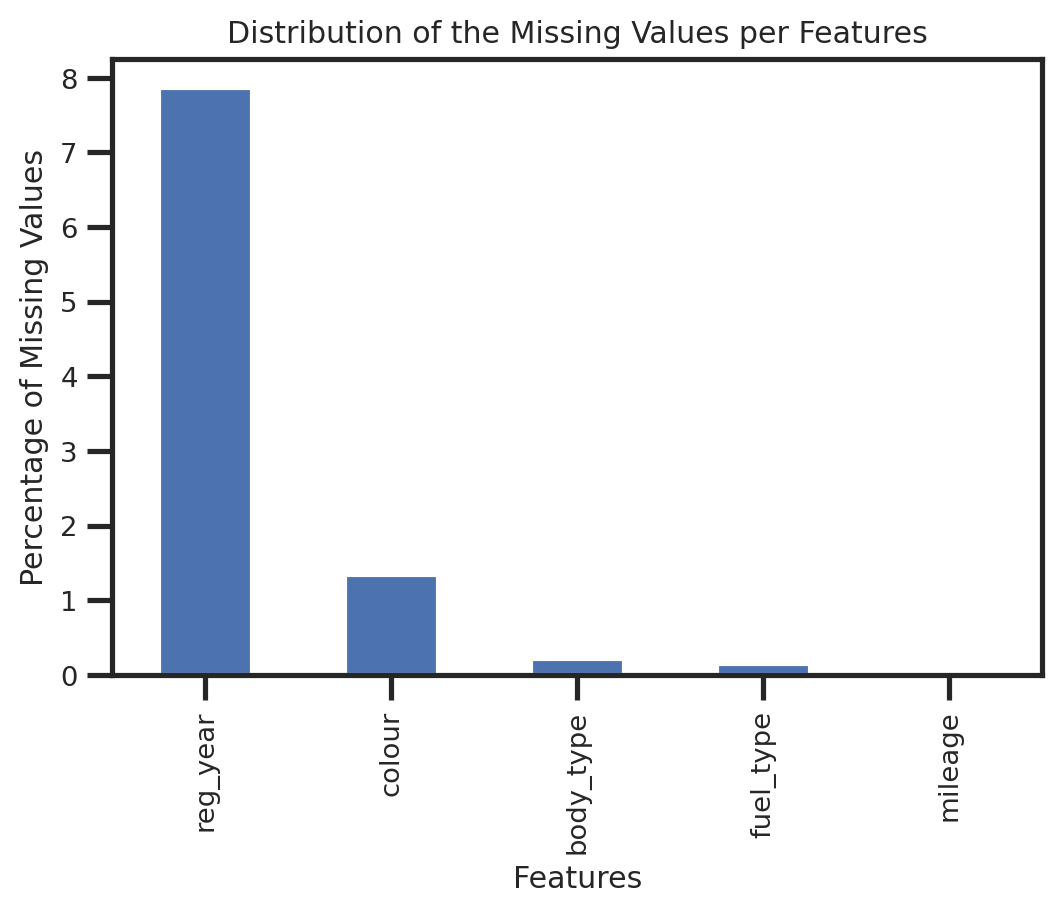

In [ ]:
print ("The number of the missing values per each feature is as follows:\n",auto_df.isnull().sum())
round((auto_df.isnull().sum()/len(auto_df))*100,2)[auto_df.isnull().sum()>0].sort_values(ascending=False).plot(
        kind="bar",
        title = "Distribution of the Missing Values per Features",
        xlabel = "Features",
        ylabel = "Percentage of Missing Values",
);

As shown, the `mileage, colour, reg_year, body_type, and fuel_type` are containing missing values with `reg_year` having the biggest ratio 
(~ 8%). To approach filling the missing values, I have to first understand their relation through the matrix plot below:

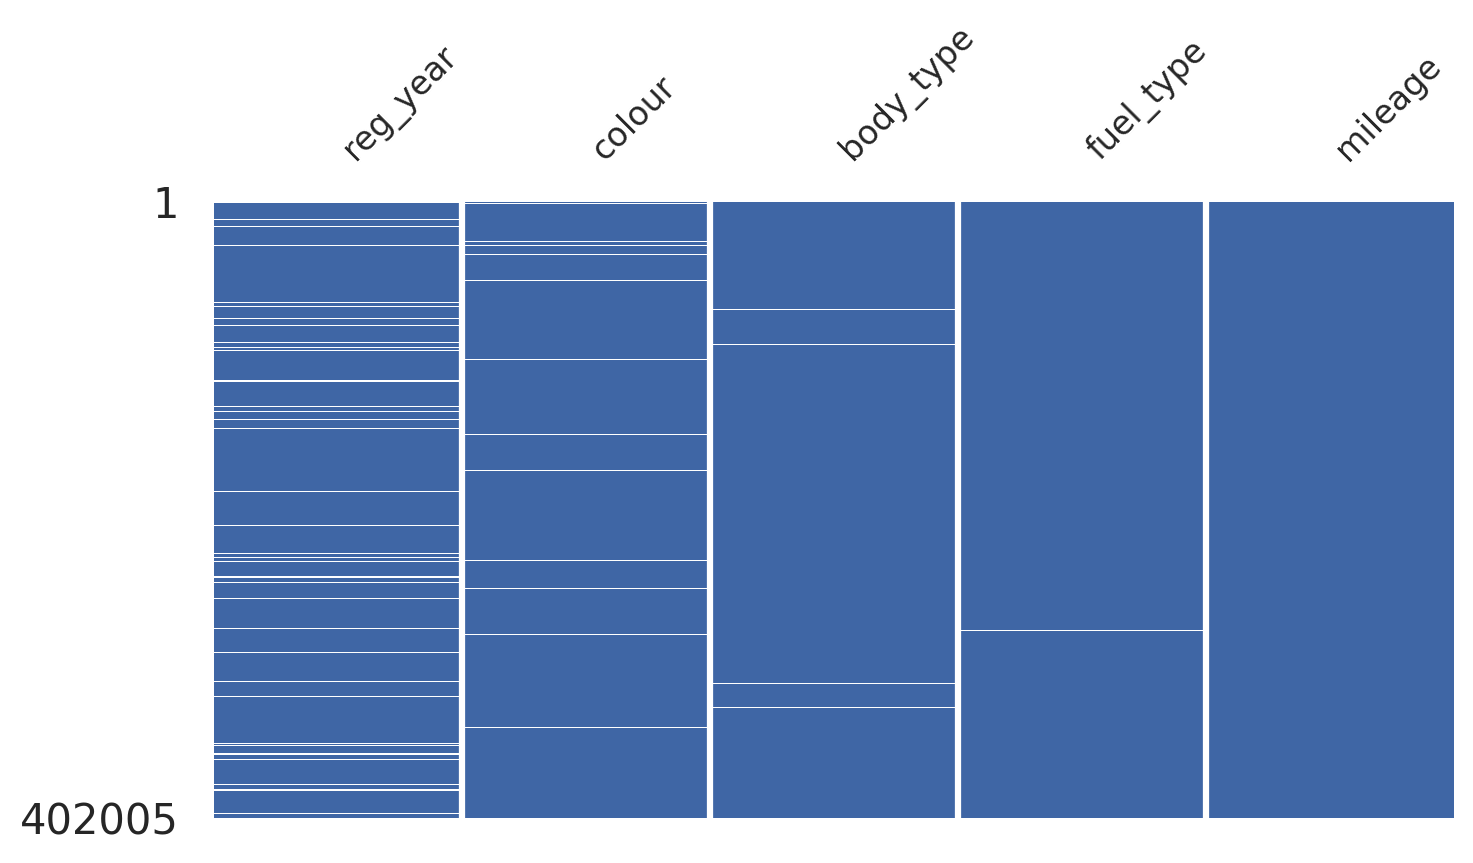

In [ ]:
msno.matrix(
    auto_df[['reg_year','colour','body_type','fuel_type','mileage']],
    sparkline=False,
    figsize=(8,4),
    fontsize=12,
    color = (0.250, 0.400, 0.650)
);

The figure above, shows that there are no significant relation between the missing values (e.g. the pattern of the missing values is arbitrary). Another test that I can depend to prove the randomness of the missing values is to visualize the correlation of the missing values using `msno.heatmap`.

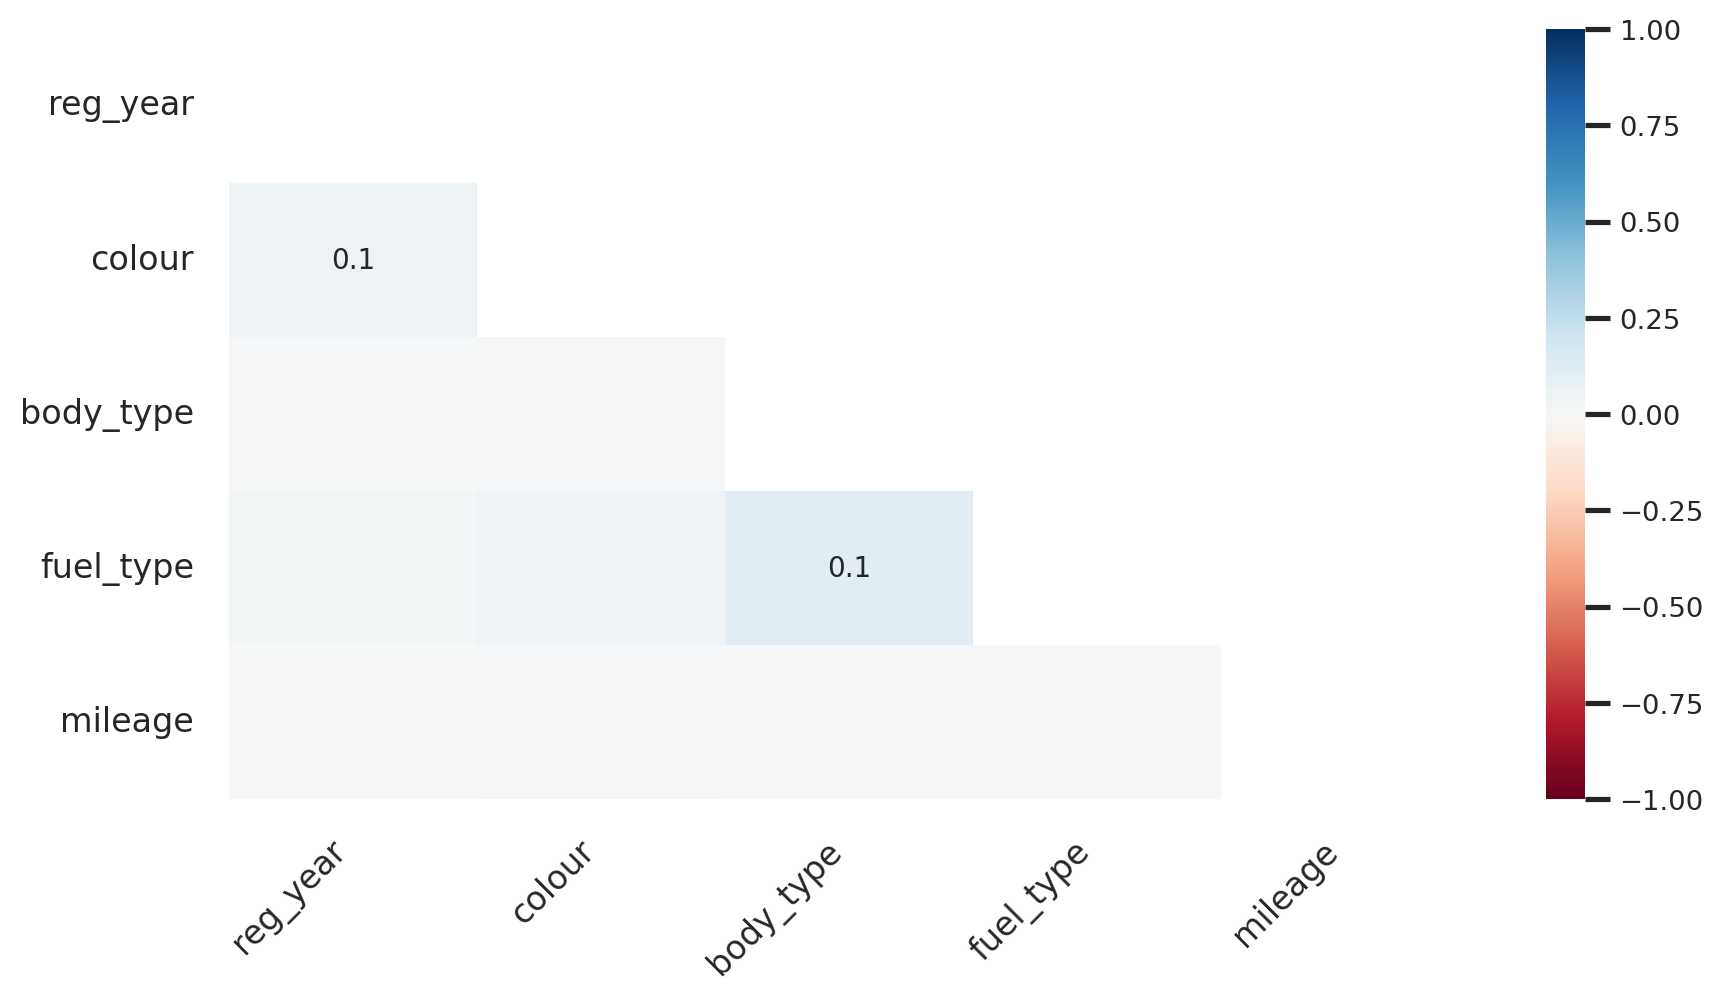

In [ ]:
msno.heatmap(
    auto_df[['reg_year','colour','body_type','fuel_type','mileage']],
    figsize=(10,5),
    fontsize=12
); 

From the figure above, I can see that there is a weak correlation (~ %10) between the features with missing values, henca I can say that the values are Missing completely at Random (MCAR).



#### 1.5.1 Registration Year

The ratio of missing values in `reg_year` is signiticantly higher than other features. I need to check if the missing data has any relation with the information in other features. The domain knowledge is playing a key role here, and saves us lots of time to determine the root cause of this issue. One possible cause is, NEW cars are usually not registered (hence, doesn't have the `reg_year`). Let's have a look at that:

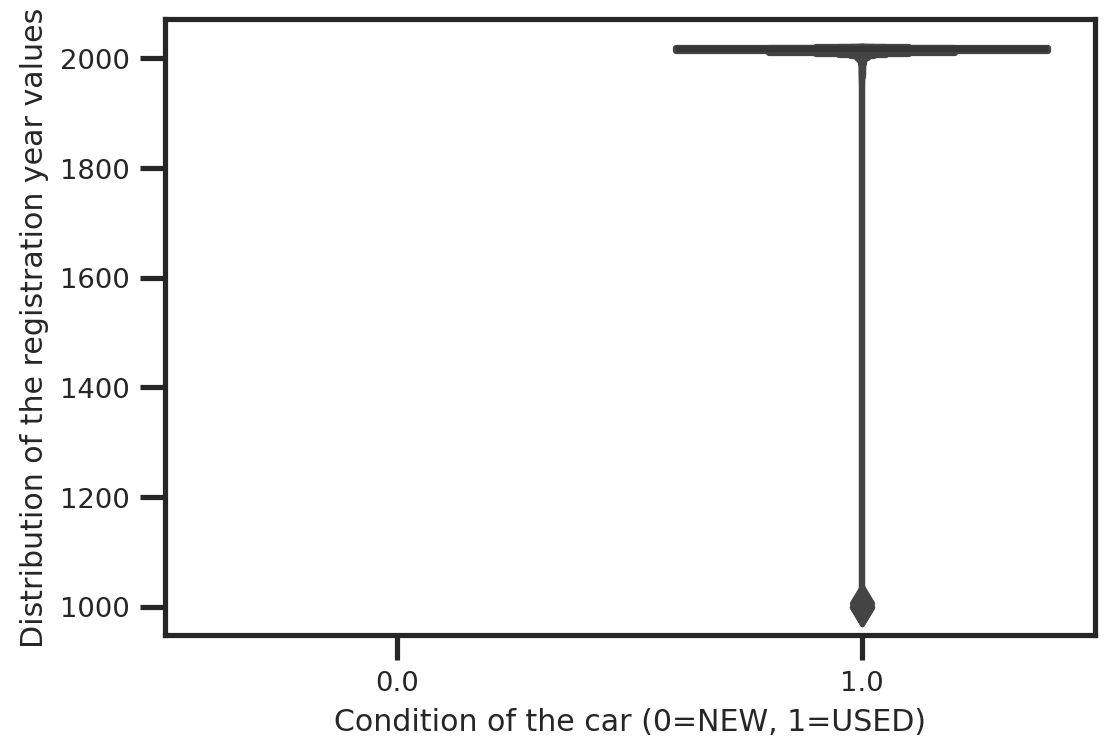

In [ ]:
sns.boxenplot(data = auto_df, x = 'condition', y = 'reg_year', palette = 'husl').set(
    xlabel = "Condition of the car (0=NEW, 1=USED)",
    ylabel="Distribution of the registration year values");

As we can see from the graph, there is no registration year recorded for the new cars. The most accurate approach is to fill the them with the most recent registration year of the cars. In another words, I fill the missing values with the maximum value of the registration year (which is 2020) as below: 

In [ ]:
auto_df["reg_year"].replace(np.nan, auto_df["reg_year"].max(), inplace=True)

#### 1.5.2 Mileage

In order to fill the missing values of the `mileage`, the quickest approach is to fill it in relation to the car's year of registration (`reg_year`). First let's understand the average distribution of `mileage` per each year:

```
# This is formatted as code
```

 

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


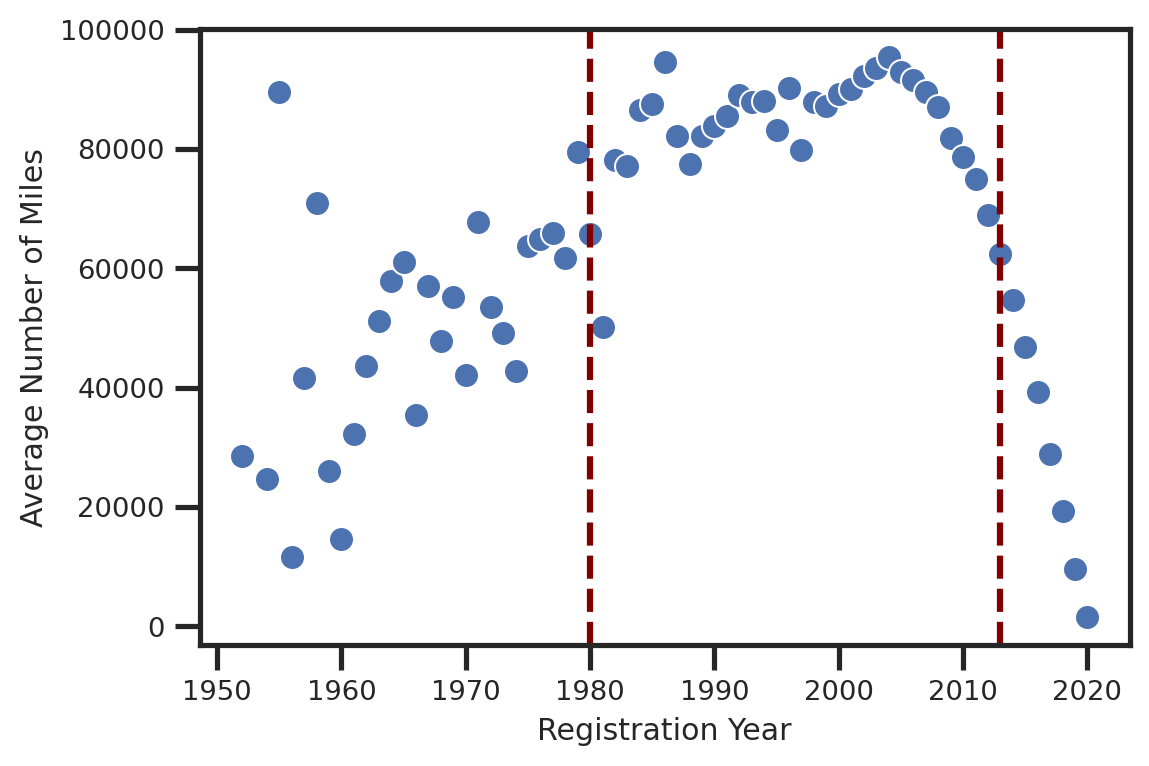

In [ ]:
sns.scatterplot(
    data = auto_df[(auto_df["reg_year"]>1950) & (auto_df["mileage"]<250000)].groupby(by="reg_year").mean(),
     x="reg_year", y="mileage"
).set(
    xlabel = "Registration Year",
    ylabel="Average Number of Miles");

plt.axvline(x = 1980, color ="maroon", linestyle ="--");
plt.axvline(x = 2013, color ="maroon", linestyle ="--");

As we can see from the graph, the cars between 1980 to 2013 (approximate) are having higher miles in average, while this number is droping significantly for the cars registered before 1980 and after 2015. 

In [ ]:
auto_df.loc[(((auto_df.reg_year>=1980) & (auto_df.reg_year<=2013)) & (auto_df.mileage.isnull())) , 'mileage'] = auto_df.loc[(auto_df.reg_year>=1980) & (auto_df.reg_year<=2013), 'mileage'] .mean()
auto_df.loc[(((auto_df.reg_year<1980) | (auto_df.reg_year>2013)) & (auto_df.mileage.isnull())) , 'mileage'] = auto_df.loc[((auto_df.reg_year<1980) | (auto_df.reg_year>2013)), 'mileage'] .mean()
auto_df.isnull().sum()

mileage         0
colour       5378
maker           0
model           0
condition       0
reg_year        0
price           0
body_type     837
crossover       0
fuel_type     601
dtype: int64

#### 1.5.3 Colour, Body Type, and Fuel Type

We have three categorical features (`colour`, `body_type`, `fuel_type`) left with having missing values. Our approach to handle those missing values will be the same which is to replace the null values with the categories in a random way.

As observed above, there are around 5,378 missing values in the car colours `colour`. To approach this, the number of observation should be identified for each colour in the dataset.

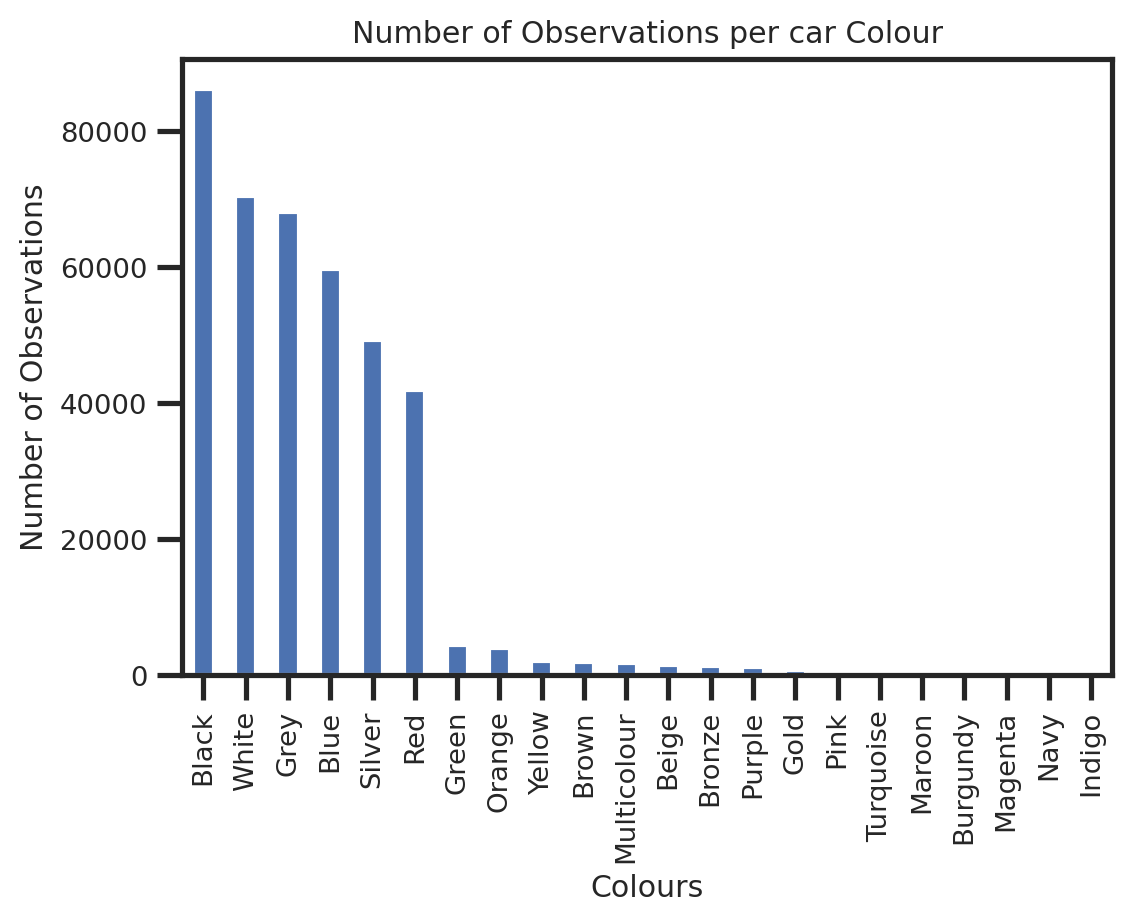

In [ ]:
auto_df.groupby(by = "colour").size().sort_values(ascending=False).plot(
        kind="bar",
        title = "Number of Observations per car Colour",
        xlabel = "Colours",
        ylabel = "Number of Observations",
);

We can see that `Black`, `White`, `Blue`, `Grey`, `Silver`, and `Red` cars are comprising around %80 of the total population. Hence, I replace the null values with those top 6 colours [randomly:](https://stackoverflow.com/questions/36413314/filling-missing-data-by-random-choosing-from-non-missing-values-in-pandas-datafr)


In [ ]:
top_6_colours = np.array (auto_df.groupby(by = "colour").size().sort_values(ascending=False).head(6).reset_index().colour) # Selecting top 6 colours

auto_df["colour"].fillna(random.choice(top_6_colours), inplace=True) # Randomly assigning top 6 colours to the NaN values

auto_df.isnull().sum() # Checking final results

mileage        0
colour         0
maker          0
model          0
condition      0
reg_year       0
price          0
body_type    837
crossover      0
fuel_type    601
dtype: int64

Both `body_type` and `fuel_type` have relatively low number of missing values, and I am using the same approach used to fill the missing values for `colour`.




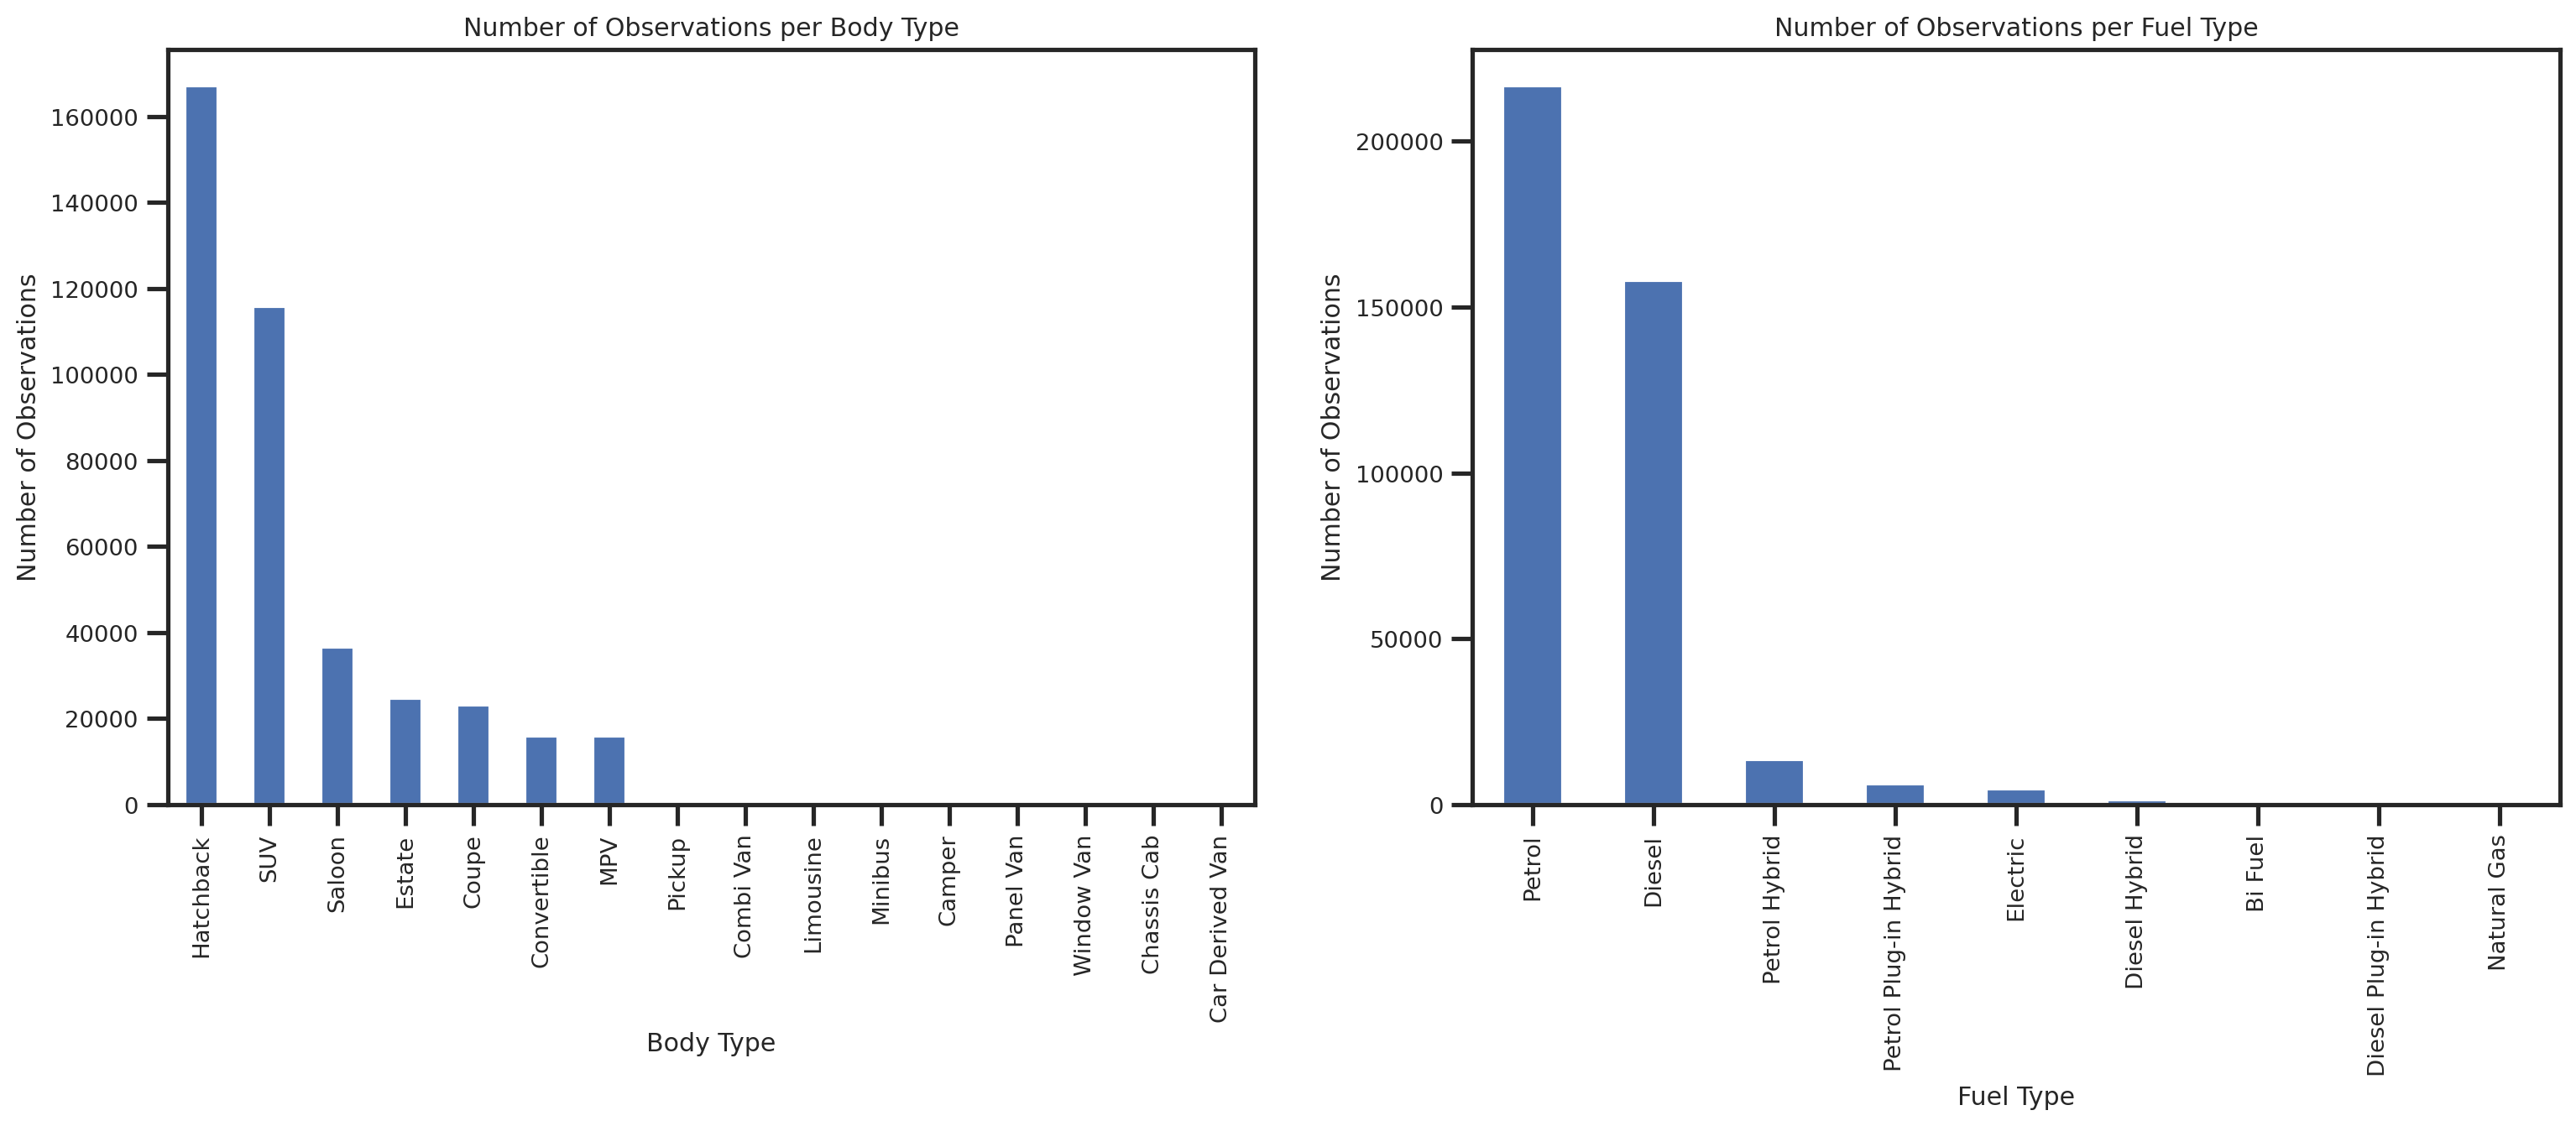

In [ ]:
plt.figure(figsize=(6, 5))
plt.subplots_adjust(bottom=0.1, right=2.5, top=1)

plt.subplot(1, 2, 1)
auto_df.groupby(by = "body_type").size().sort_values(ascending=False).plot(
        kind="bar",
        title = "Number of Observations per Body Type",
        xlabel = "Body Type",
        ylabel = "Number of Observations",
);

plt.subplot(1, 2, 2)
auto_df.groupby(by = "fuel_type").size().sort_values(ascending=False).plot(
        kind="bar",
        title = "Number of Observations per Fuel Type",
        xlabel = "Fuel Type",
        ylabel = "Number of Observations"
);

In [ ]:
top_7_bodyType = np.array (auto_df.groupby(by = "body_type").size().sort_values(ascending=False).head(7).reset_index().body_type)
auto_df["body_type"].fillna(random.choice(top_7_bodyType), inplace=True)
#--------------------------------------------------------------------------------------------------------------------------------
top_3_fuelType = np.array (auto_df.groupby(by = "fuel_type").size().sort_values(ascending=False).head(7).reset_index().fuel_type)
auto_df["fuel_type"].fillna(random.choice(top_3_fuelType), inplace=True)
#--------------------------------------------------------------------------------------------------------------------------------
auto_df.isnull().sum()

mileage      0
colour       0
maker        0
model        0
condition    0
reg_year     0
price        0
body_type    0
crossover    0
fuel_type    0
dtype: int64

### 1.6 Outliers

Some of the features are having abnormal values that are too extreme (outliers), and will affect the analysis and predictions. to better understand the outliers, let's look at the statistical information of the dataset:


In [ ]:
auto_df.describe()

,mileage,condition,reg_year,price,crossover
count,402005.000000,402005.000000,402005.000000,4.020050e+05,402005.000000
mean,37745.061332,0.922267,2015.402687,1.734197e+04,0.004465
std,34829.087783,0.267751,7.750857,4.643746e+04,0.066672
min,0.000000,0.000000,999.000000,1.200000e+02,0.000000
25%,10487.000000,1.000000,2014.000000,7.495000e+03,0.000000
50%,28623.000000,1.000000,2017.000000,1.260000e+04,0.000000
75%,56886.000000,1.000000,2018.000000,2.000000e+04,0.000000
max,999999.000000,1.000000,2020.000000,9.999999e+06,1.000000


From the statistical table above, I can see that there are some outliers in `mileage`, `reg_year`, and `price`. Let's explore each feature seperately: 

#### 2.6.1 Registration Year

For the `reg_year`, there are some outliers in the dataset that are shown below:

In [ ]:
auto_df.loc[auto_df ['reg_year']<1920].head()

,mileage,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,
202006270588110,14000.0,Blue,Toyota,Prius,1.0,1007.0,7000.0,Hatchback,0.0,Petrol Hybrid
202010155035879,96659.0,Black,Audi,A4 Avant,1.0,1515.0,10385.0,Estate,0.0,Diesel
202009163810376,37771.0,Black,Smart,fortwo,1.0,1063.0,4785.0,Coupe,0.0,Petrol
202008102305925,30000.0,Red,Toyota,AYGO,1.0,1009.0,4695.0,Hatchback,0.0,Petrol
202010064654489,27200.0,Black,MINI,Clubman,1.0,1016.0,18990.0,Estate,0.0,Diesel


To approach this I will follow the below steps:

1. Appearantly there is a typo error for the 4 digit of the `reg_year`s starting with one. For example a year of 1007 could be just 2007 (my best guess. I will replace the first digit of each year to 2 as follows:



In [ ]:
def year_corr(number): 

  if 1000<number<1930:
    number = str(number)
    number  = "2" + number[1:]
    number = float(number)
  elif (number>2030 or number<1000):
    number=round (auto_df["reg_year"].mean(), 0)
    
  if 1930 <= number <= 2020:
    return number
  else: 
    return round(auto_df["reg_year"].mean(),0)

auto_df['reg_year'] = auto_df['reg_year'].apply(year_corr)

#### 1.6.2 Mileage

According to an article from [Housegrail](https://housegrail.com/car-longevity-statistics/), the average expected life span of a car is 200,000 miles, and with proper maintenance and good driving habits from the owner it can go upto 1,000,000 miles (very rare). In the AutoTrade dataset, I can see that there are many cars which their mileage are above the mentioned threshold. For this specific project, I take the median of 300,000 miles as a cap, and consider all the values above the threeshold as outliers.

There are 31 cars which their mileage is above 300,000


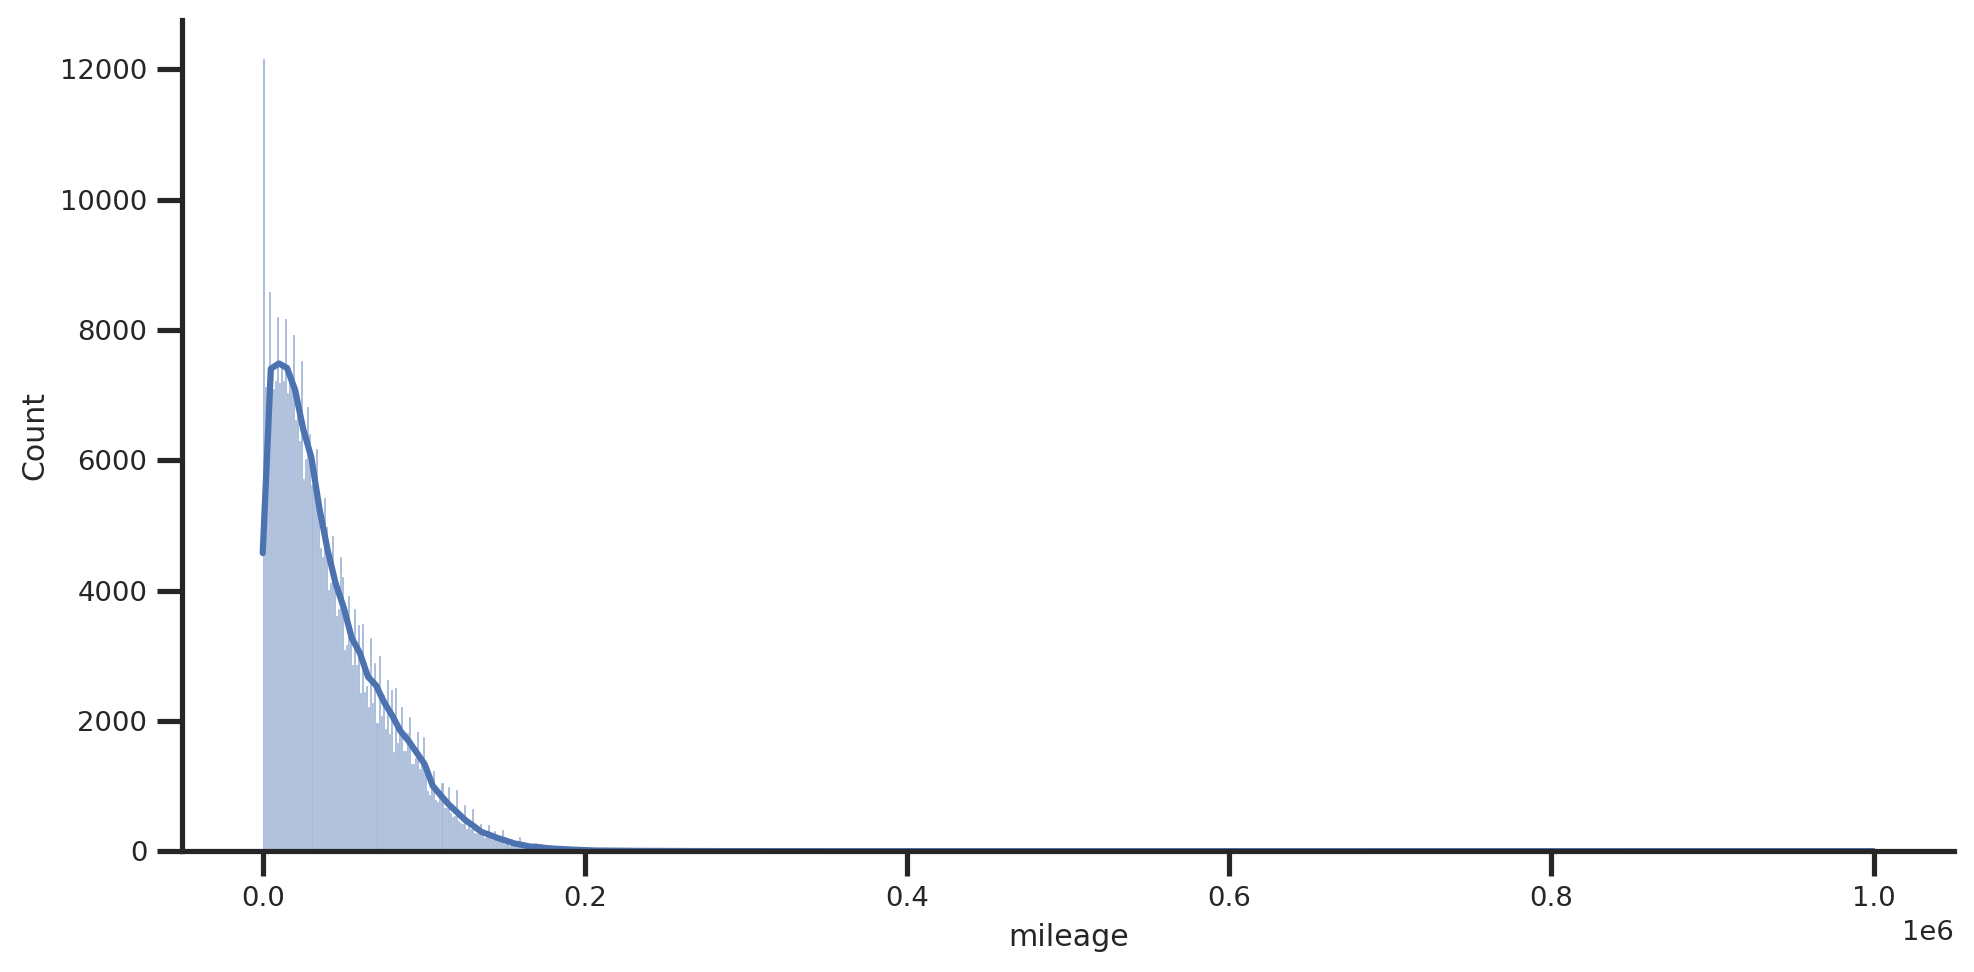

In [ ]:
sns.displot(auto_df[auto_df["mileage"]>10]['mileage'], kde=True, aspect=2);
print(f'There are {auto_df[auto_df["mileage"]>300000]["mileage"].size} cars which their mileage is above 300,000')

We change the mileage of those cars, with the mean value of the cars which their mileage are under 300,000 miles:

In [ ]:
auto_df.loc[auto_df["mileage"]>300000, "mileage"] = round(auto_df.loc[auto_df["mileage"]<300000, "mileage"].mean(), 0)

It is also important to identify any used car with 0 miles. 

In [ ]:
auto_df[(auto_df["mileage"]==0) & (auto_df["condition"]==1)].head()

,mileage,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,
202009254208702,0.0,Grey,Land Rover,Range Rover Velar,1.0,2020.0,52995.0,SUV,0.0,Diesel
202011015669636,0.0,Silver,Vauxhall,Insignia,1.0,2013.0,2975.0,Hatchback,0.0,Diesel
202010014447366,0.0,Grey,Mercedes-Benz,CLA Class,1.0,2020.0,34995.0,Estate,0.0,Petrol
202009304376426,0.0,Black,Land Rover,Range Rover,1.0,2020.0,82750.0,SUV,0.0,Diesel
202008283030532,0.0,Black,Audi,A1,1.0,2013.0,8000.0,Hatchback,0.0,Diesel


There are 355 car that are used but their mileage is 0. We can treat those values according to their `reg_year` as below: 

1. If the `reg_year` of the car is 2020, then this car is considered as new (`condition` == 0) 
2. If the `reg_year` of the car is less than 2020, then the mean of `mileage` would be assigned as a new mileage.

In [ ]:
auto_df.loc[(auto_df["mileage"]==0) & (auto_df["condition"]==1) & (auto_df["reg_year"]==2020), "condition"] = 0

auto_df.loc[(auto_df["mileage"]==0) & (auto_df["condition"]==1) & (auto_df["reg_year"]<=2019), "mileage"] = round(auto_df["mileage"].mean(),0)

# ############# Checking the Results ################

auto_df[(auto_df["mileage"]==0) & (auto_df["condition"]==1)].head()

,mileage,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,


#### 1.6.3 Price

Based on the `describe()` table above, there are a number of cars with exteremly high prices (up to 10 Million Pounds), as shown below: 

There are 32 cars which their price between 1-10 million pounds 



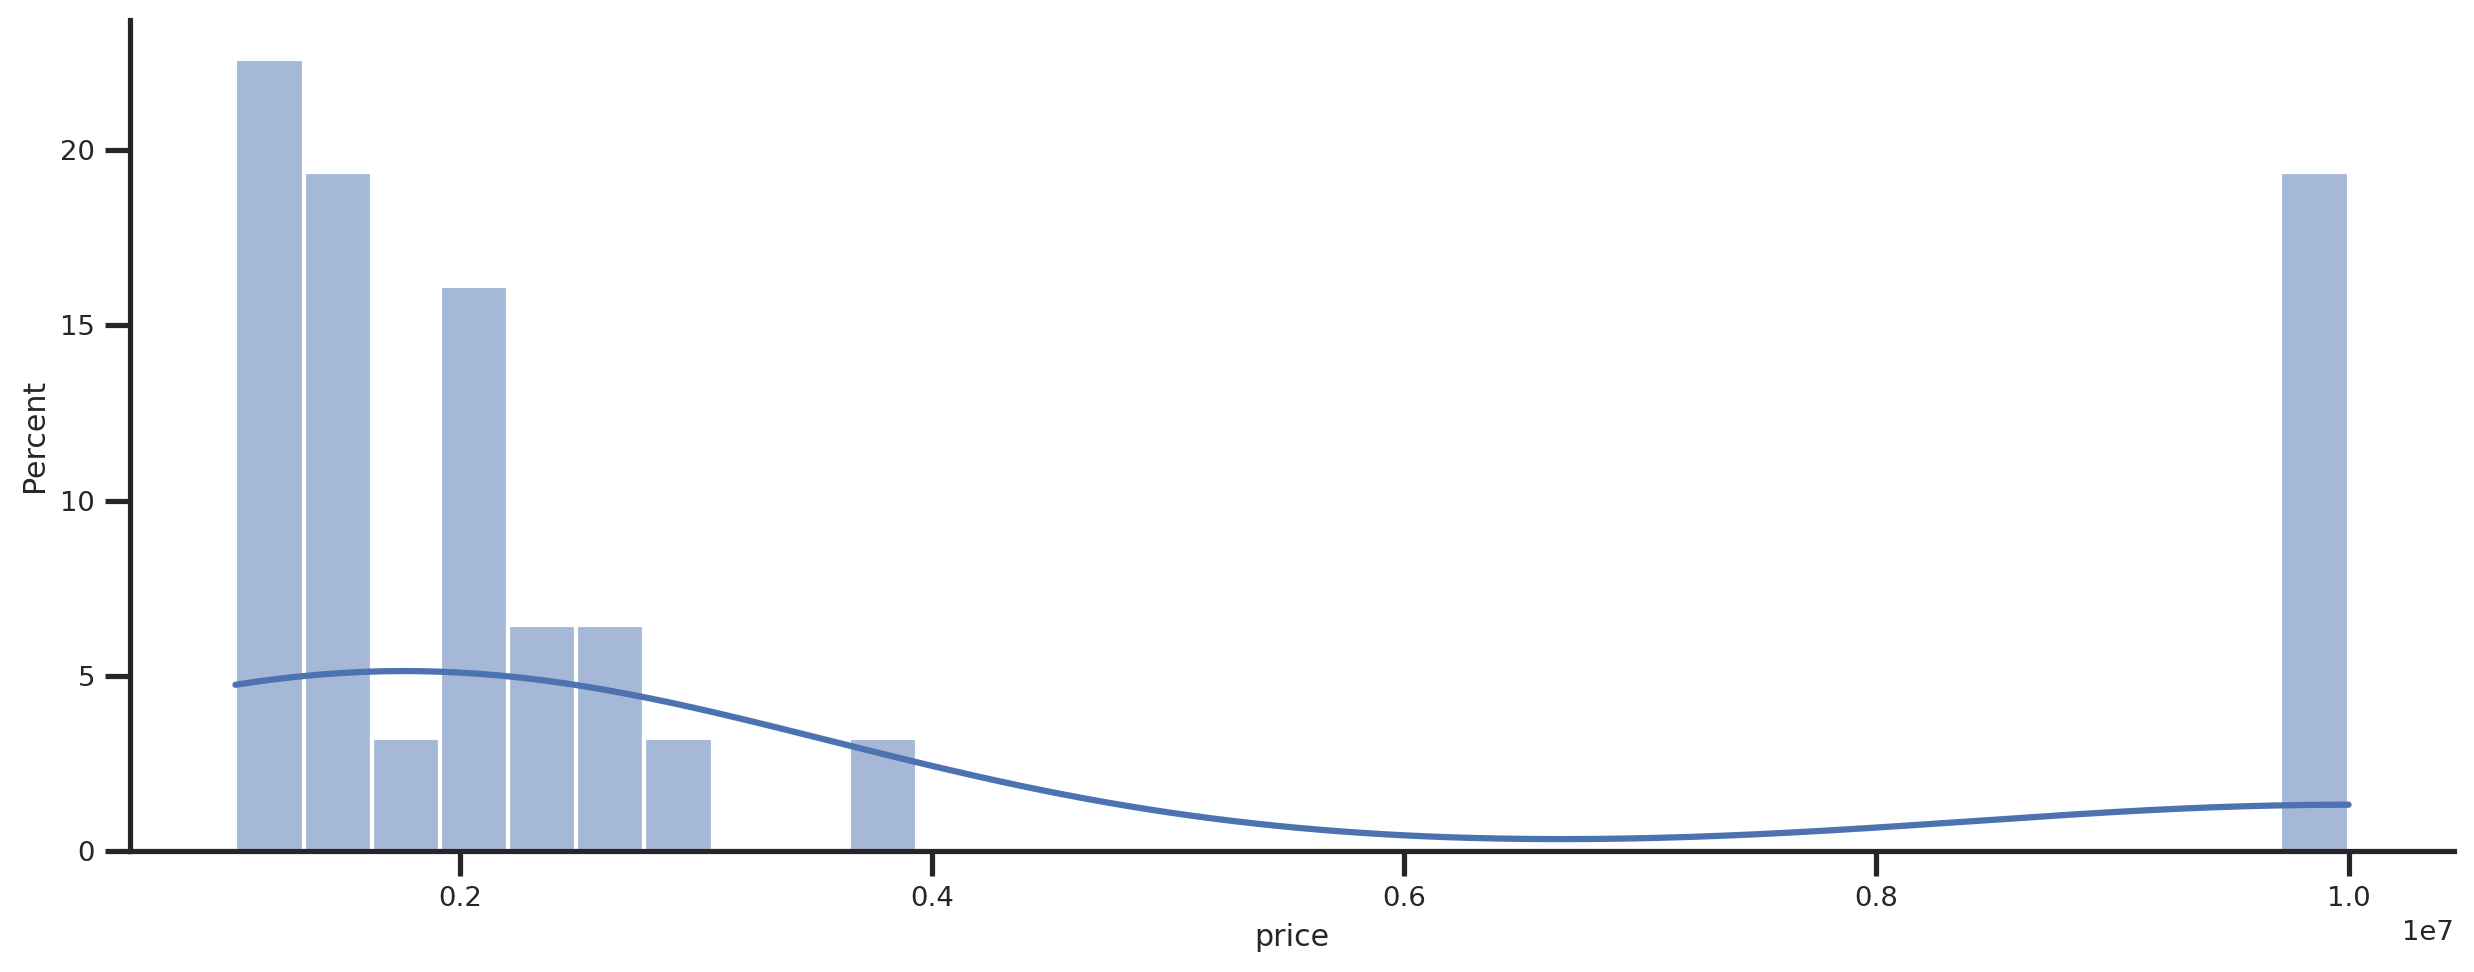

In [ ]:
print(f'There are {auto_df[auto_df["price"]>=1000000]["price"].size} cars which their price between 1-10 million pounds \n')
sns.displot(x = auto_df[auto_df["price"]>1000000]["price"],
            bins=auto_df[auto_df["price"]>1000000]["price"].size,
            stat='percent',
            kde=True,
            aspect=2.5
);

At this stage, it is important to further investigate the data, since some of the outliers might actually be genuine observations. I approach this issue by grouping the outliers by car makers:

In [ ]:
auto_df[auto_df["price"]>=1000000].groupby(by=["maker"]).size().sort_values(ascending=False).head(10)

maker
Ferrari          11
Bugatti           6
Porsche           6
McLaren           4
Lamborghini       1
Maserati          1
Aston Martin      1
Pagani            1
Mercedes-Benz     1
AC                0
dtype: int64

As we can see most of the highley priced cars are belonging to luxorious car brands. Hence, the price of those cars are potentially genuine. However, I have around 32 observations of such cars, which is less than %00001 of the total observations. To approach this issue, and for this project, I am capping those outliers with the maximum prices mentioned above (1,000,000) 

In [ ]:
auto_df.loc[auto_df["price"]>=1000000, "price"]=1000000

### 1.7 Spliting, and obtaining train/validation/test folds

The following taska are performed in this section: 
1. A sample (%10) of the data will be extracted to reduce the computational time. 
2. Spliting the features and the target.
3. Obtaining the train/validation/test folds. 

In [ ]:
auto_df = auto_df.groupby('maker', group_keys=False).apply(lambda x: x.sample(frac=0.10))
auto_df.shape

(40194, 10)

In [ ]:
X = auto_df.drop(columns='price')
y = auto_df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=20230407, test_size=1/4
)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30145, 9), (10049, 9), (30145,), (10049,))

In [ ]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40194 entries, 202009224046503 to 202010074713057
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   mileage    40194 non-null  float64 
 1   colour     40194 non-null  category
 2   maker      40194 non-null  category
 3   model      40194 non-null  category
 4   condition  40194 non-null  float64 
 5   reg_year   40194 non-null  float64 
 6   price      40194 non-null  float64 
 7   body_type  40194 non-null  category
 8   crossover  40194 non-null  float64 
 9   fuel_type  40194 non-null  category
dtypes: category(5), float64(5)
memory usage: 2.1 MB


## Section 2: Feature Engineering 



### 2.1 Feature Transformation

After cleaning and understanding the dataset, now I have to start transforming our data to be used for predictions. As mentioned earlier, there are 5 categorical features that are not interpretable by our 
Machine Learning algorithm. Hence, I have to handle those categorical features, and transform them to numerical value. There are different transformation approaches and their usage depends on the distribution and frequency of our categorical values. Let's first recall the column types and the number of categorical values per each feature: 

In [ ]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40194 entries, 202009224046503 to 202010074713057
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   mileage    40194 non-null  float64 
 1   colour     40194 non-null  category
 2   maker      40194 non-null  category
 3   model      40194 non-null  category
 4   condition  40194 non-null  float64 
 5   reg_year   40194 non-null  float64 
 6   price      40194 non-null  float64 
 7   body_type  40194 non-null  category
 8   crossover  40194 non-null  float64 
 9   fuel_type  40194 non-null  category
dtypes: category(5), float64(5)
memory usage: 2.1 MB


In [ ]:
auto_df[categorical_features].describe()

,colour,maker,model,body_type,fuel_type
count,40194,40194,40194,40194,40194
unique,20,73,787,15,8
top,Black,BMW,Golf,Hatchback,Petrol
freq,8608,3738,1183,16721,21814


### 2.2 Target Encoder
We can see that there are 5 categorical features with high cardinality. To approach this specific issue, I can't use a simple encoder like one-hot-encoder since this will generate many columns. Instead, I use `Target Encoder` which "*features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data*" as stated from the Scikit Learn website [here](https://https://contrib.scikit-learn.org/category_encoders/targetencoder.html). 


> The major problem with this approach is data/target leakage, which refers to the leakage of data between the train and test data. An effective way to prevent the data leakage is to split test and train data before transformation as it is already performed. 

Then, I am going to apply the `fit_transform` on the train data, but `transform` only on the test data. This will help us further minimize the leakage between the train and test features.

In [ ]:
categorical_features = ["colour", "maker", "model", "body_type", "fuel_type"]
transformer_pipln = Pipeline(
    steps=[
        ("encoder", TargetEncoder(cols=categorical_features, return_df=True)),
    ]
).set_output(transform='pandas')
transformer_pipln

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['colour', 'maker', 'model', 'body_type',
                                     'fuel_type']))])

It is also important to apply one-hot-encoding on `crossover` and `condition` to make the data balanced and help the model make better prediction: 

In [ ]:
X_train = pd.get_dummies(X_train, columns=["condition","crossover"])
X_test = pd.get_dummies(X_test, columns=["condition","crossover"])

### 2.3 Rescaling Features

Another important step would be to scale our features that are different in units (`mileage` in this case). This ensure that the range and magnitude of the values do not disproportionately influence the models' learning process in the next steps. To perform this step, a `MinMaxScaler` is used to scale the mileage between the range of 0 to 1 as below: 

In [ ]:
mileage_scaler = ColumnTransformer(
    [('scaler', MinMaxScaler(), ['mileage'])],
    remainder='passthrough', 
    verbose_feature_names_out=False
)
transformer_pipln.steps.append(['scaler',mileage_scaler])
transformer_pipln.set_output(transform='pandas')

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['colour', 'maker', 'model', 'body_type',
                                     'fuel_type'])),
                ['scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['mileage'])],
                                   verbose_feature_names_out=False)]])

### 2.4 Adding Polynomial Features

Polynomial functions allow us to capture more complex and non-linear relationships between variables in machine learning. In real-world datasets, the relationship between features and the target variable is often not a straight line, but instead exhibits curves, bends, or other non-linear patterns. By using polynomial functions, we can represent and model these non-linear relationships more accurately. Below is, the polynomial features are added to the existing pipeline: 

>Note: The degree of the polynomial has been determined throgh running a GridSearchCV on the `mileage` as the only numerical feature.

In [ ]:
#Adding Polynomial Features to the Pipeline
poly_pipln = Pipeline(
    [('polynomial', PolynomialFeatures(degree=3, include_bias=False))]
).set_output(transform='pandas')

poly_pipln

Pipeline(steps=[('polynomial',
                 PolynomialFeatures(degree=3, include_bias=False))])

## Section 3: Feature Selection and Dimensionality Reduction

After encodeding, scaling and adding polynomial features the dimensionality reduction should be performed to select the most relevant features from the train and test datasets. This will improve model performance by eliminating irrelevant or redundant features, reducing overfitting, and enhancing interpretability.

### 3.1 Manual Feature Selection
In this dataset, many features play a crucial role in determining car `price`s. For example, `mileage` is a critical factor as lower mileage generally corresponds to a higher price. Additionally, the condition of the car, assessed through the `condition`, significantly impacts its value, with well-maintained cars commanding higher prices. The registration year `reg_year` also holds relevance, as newer cars tend to be more expensive. Categorical variables, such as `colour`, `maker`, `model`, `body_type`, and `fuel type`, contribute to pricing variations based on consumer preferences and market trends. Also, certain combinations of car makers and models may hold a reputation for quality or desirability, influencing prices accordingly. To further  explore the relationship of the features with the target, a univariate statistical test performed using `SelectKBest` and `f_regression` as a score function.

First, we need to transform the dataset, apply the polynomial (on the `mileage`) and prepare our train and test transformed datasets:

In [ ]:
X_train_transformed = transformer_pipln.fit_transform(X_train, y_train)
mileage_df = pd.DataFrame(X_train["mileage"])
mileage_df = poly_pipln.fit_transform(mileage_df, y_train)
X_train_transformed = pd.concat([X_train_transformed, mileage_df.drop(columns="mileage")], axis=1)

# Applying the same transformation on the test data
X_test_encoded = transformer_pipln.named_steps['encoder'].transform(X_test)
X_test_scaled = transformer_pipln.named_steps['scaler'].fit_transform(X_test_encoded)
test_mileage_df = pd.DataFrame(X_test["mileage"])
test_mileage_df = poly_pipln.fit_transform(test_mileage_df, y_test)
X_test_transformed = pd.concat([X_test_scaled, test_mileage_df.drop(columns="mileage")], axis=1)

Then, we rank the features based on the f_regression's F-Static and P-values as below:

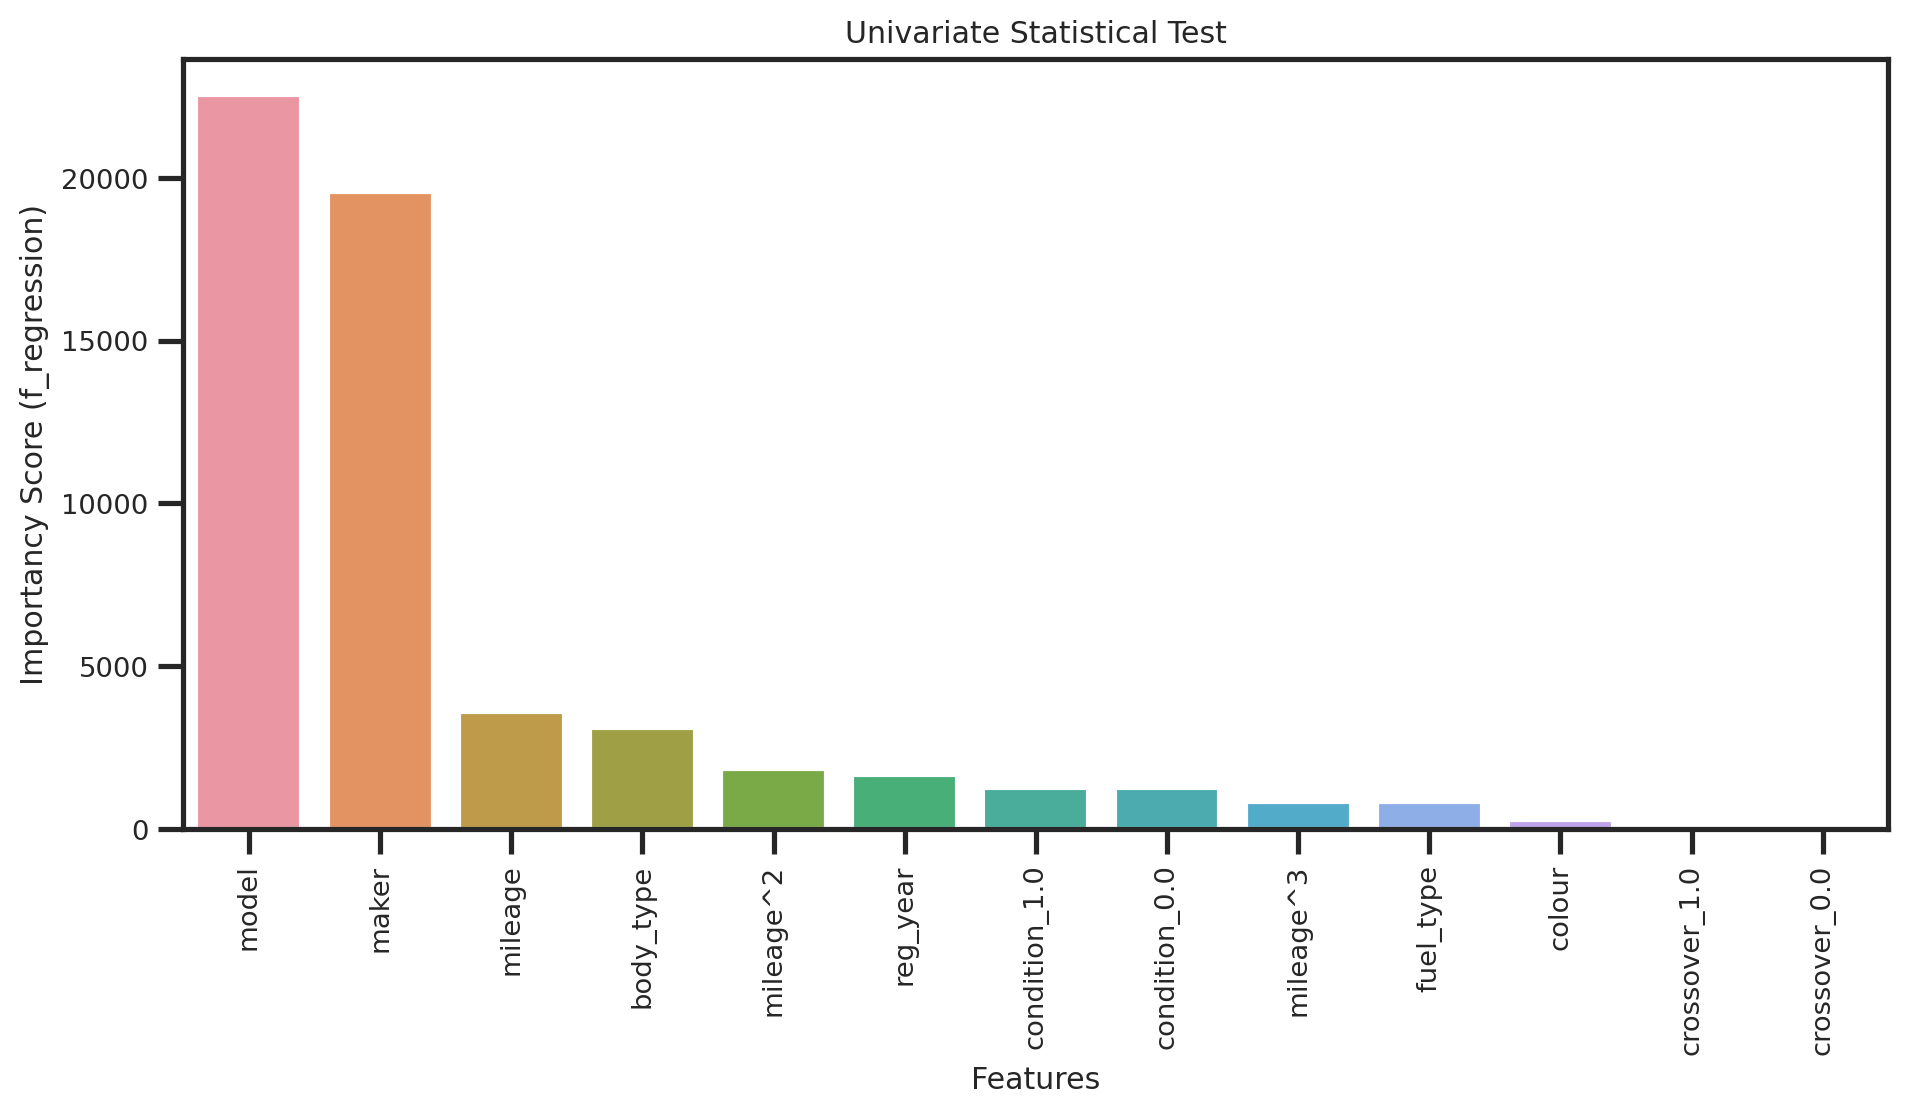

In [ ]:
# Ranking features based on the f_regression metrics
feature_ranks = SelectKBest(score_func = f_regression, k=X.shape[1]); # I use f_regression as a scoring function, and k determines the number of features
feature_ranks.fit(X_train_transformed, y_train); # Fiting the train data in the SelectKBest

feature_ranks = pd.concat(
    [pd.DataFrame(X_train_transformed.columns,columns=["column_name"]),   #Concatinating score with their correspondent feature names
    pd.DataFrame(feature_ranks.scores_, columns=["score"])], 
    axis=1
)

plt.figure(figsize = (11,5))
g = sns.barplot(data = feature_ranks.sort_values(by="score", ascending=False), x="column_name", y="score")
g.set_xticklabels(g.get_xticklabels(), rotation=90);
g.set_xlabel("Features")
g.set_ylabel("Importancy Score (f_regression)");
g.set_title("Univariate Statistical Test");

As shown above, the `model`, `maker`, `mileage`, `body_type`, `reg_year`, and `mileage^2` have the most significant impact on the `price` of the car. Furthermore, these features have a higher impact when they interact with other features. Also, those features are usually are the selecting factors when the user is buying a new car. That's worth mentioning that the `crossover` feature is not making a significant contribution in this regression problem, and also that is usually the case in the real world. Hence, the `crossover` will be droped accordingly: 

In [ ]:
X_train_transformed.drop("crossover_0.0", axis=1, inplace=True)
X_train_transformed.drop("crossover_1.0", axis=1, inplace=True)
X_test_transformed.drop("crossover_0.0", axis=1, inplace=True)
X_test_transformed.drop("crossover_1.0", axis=1, inplace=True)

### 3.1 Sequential Feature Selector (SFS) - Forward

While all the mentioned features are considered important, it is also interesting to know the individual performance of each feature in improving the accuracy of the model. For thie particular dataset, the Sequential Feature Selector (SFS) is used to determine and rank the predictive power for the top 10 features on `Ridge` as one of the regressor models. RFE operates by building a feature subset in a forward or backward sequential manner.

In [ ]:
sfs_forward = SequentialFeatureSelector(
    Ridge(), n_features_to_select=10, direction="forward", scoring='neg_root_mean_squared_error'
)

In [ ]:
%%capture
sfs_forward.fit(X_train_transformed, y_train)
sfs_selected_features = sfs_forward.get_feature_names_out().tolist()

In [ ]:
sfs_selected_features

['mileage',
 'colour',
 'maker',
 'model',
 'body_type',
 'fuel_type',
 'condition_0.0',
 'condition_1.0',
 'mileage^2',
 'mileage^3']

As shown above, the model ranked the `reg_year` of the car as not an important predictor and exlucded that. However, we have proved earlier and based on the domain knowledge, `reg_year` is a significant factor that determines the price of the car. Hence, 
we keep the features as it is and instead we remove the `mileage 3` as it doesn't seems like a good predictor in both manual and automated feature selection processes. 

In [ ]:
X_train_transformed.drop("mileage^3", axis=1, inplace=True)
X_test_transformed.drop("mileage^3", axis=1, inplace=True)

In [ ]:
X_train_transformed.columns

Index(['mileage', 'colour', 'maker', 'model', 'reg_year', 'body_type',
       'fuel_type', 'condition_0.0', 'condition_1.0', 'mileage^2'],
      dtype='object')

In [ ]:
X_test_transformed.columns

Index(['mileage', 'colour', 'maker', 'model', 'reg_year', 'body_type',
       'fuel_type', 'condition_0.0', 'condition_1.0', 'mileage^2'],
      dtype='object')

## Section 4: Model Building

After preparing the data three regression models `LinearRegression`, `RandomForestRegressor`, and `GradientBoostingRegressor` will be created and trained on the prepared dataset to learn patterns and relationships between selected features and the target variable. The models will be individually evaluated for their predictive capabilities. Additionally, an ensemble approach using averaging, voting, and stacking will be explored to further enhance predictive performance. The optimal ensemble technique will be selected at the end based on the score and performance of models used.

### 4.1 Linear Regressor Model

Linear regression is usefule when there is a linear relationship between the features and the target variable. It provides good results if the relationship between the features and price is reasonably linear. 

In [ ]:
LR = LinearRegression()
LR.fit(X_train_transformed, y_train)

LinearRegression()

### 4.2 Random Forest Regressor Model

RandomForestRegressor is an ensemble of decision trees and can handle non-linear relationships, interactions, and outliers effectively. The AutoTrader dataset contains many outliers, linear and non-linear relations between the features and the target. Hence, Random Forest is a good choice to capture the aforementioned scenarios. Before creating the model, first a hyperparameter tuning should be performed to find the best parameters on the training dataset as below: 

In [ ]:
%%capture
"""
#--------------------------------------------THIS SECTION IS COMMENTED OUT AFTER THE INITIAL RUN-------------------------------------------
RFR = RandomForestRegressor();

RFR_param_grid = {
    'n_estimators': [50, 150, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [1, 10, 20]
}

rf_grid_search = GridSearchCV(RFR, RFR_param_grid, cv=3, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train_transformed, y_train)

# Get the best parameters and the best estimator for Gradient Boosting
rf_grid_search.best_params_

#-----------------------------------------------------------------OUTPUT-----------------------------------------------------------------------

#{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 150}
"""

As Identified above, the besst parameters for the `RandomForestRegressor` is: 

- max_depth: None
- min_sample_split: 10
- n_estimators: 150

Hence, we create the model based on the results of the `GridSearchCV` parameters: 

In [ ]:
RFR = RandomForestRegressor(max_depth=None, min_samples_split=10, n_estimators=150);
RFR.fit(X_train_transformed, y_train)

RandomForestRegressor(min_samples_split=10, n_estimators=150)

### 4.3 Gradient Boosting Regressor Model

Gradient boosting is known for its ability to handle complex relationships and capture interactions between features. In particular, this model is effective when there is a non-linear relations in the dataset. Before creating the model, first a hyperparameter tuning should be performed to find the best parameters on the training dataset as below: 

In [ ]:
%%capture
"""
 #--------------------------------------------THIS SECTION IS COMMENTED OUT AFTER THE INITIAL RUN-------------------------------------------

GBR = GradientBoostingRegressor();

GBR_param_grid = {
    'n_estimators': [50, 150, 300],
    'learning_rate': [0.05, 0.1, 0.5],
    'max_depth': [None, 10, 20]
}

gb_grid_search = GridSearchCV(GBR, GBR_param_grid, cv=3, scoring='neg_mean_squared_error')
gb_grid_search.fit(X_train_transformed, y_train)

# Get the best parameters and the best estimator for Gradient Boosting
gb_grid_search.best_params_ 

#-----------------------------------------------------------------OUTPUT-----------------------------------------------------------------------

#{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50}
"""

As Identified above, the besst parameters for the `GradientBoostingRegressor` is: 

- learning_rate: 0.1
- max_depth: 10
- n_estimators: 50

Hence, we create the model based on the results of the `GridSearchCV` parameters: 

In [ ]:
GBR = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 10, n_estimators = 50);
GBR.fit(X_train_transformed, y_train)

GradientBoostingRegressor(max_depth=10, n_estimators=50)

### 4.4 VotingRegressor Ensemble

Based on the model scores obtained, the VotingRegressor ensemble technique could be the most suitable technique which provides increased stability, reduced impact of outliers, and the utilization of diverse model strengths. By adopting this approach, we can obtain more reliable predictions for this regression problem and make more informed decisions based on the collective intelligence of the models. 

In [ ]:
ensemble = VotingRegressor(
    [
        ("LR", LR),
        ("RFR", RFR),
        ("GBR", GBR)
    ]
)
ensemble.fit(X_train_transformed, y_train)

VotingRegressor(estimators=[('LR', LinearRegression()),
                            ('RFR',
                             RandomForestRegressor(min_samples_split=10,
                                                   n_estimators=150)),
                            ('GBR',
                             GradientBoostingRegressor(max_depth=10,
                                                       n_estimators=50))])

Now we are plotting the Mean Absolute Error of each Model to determine their accuracy: 

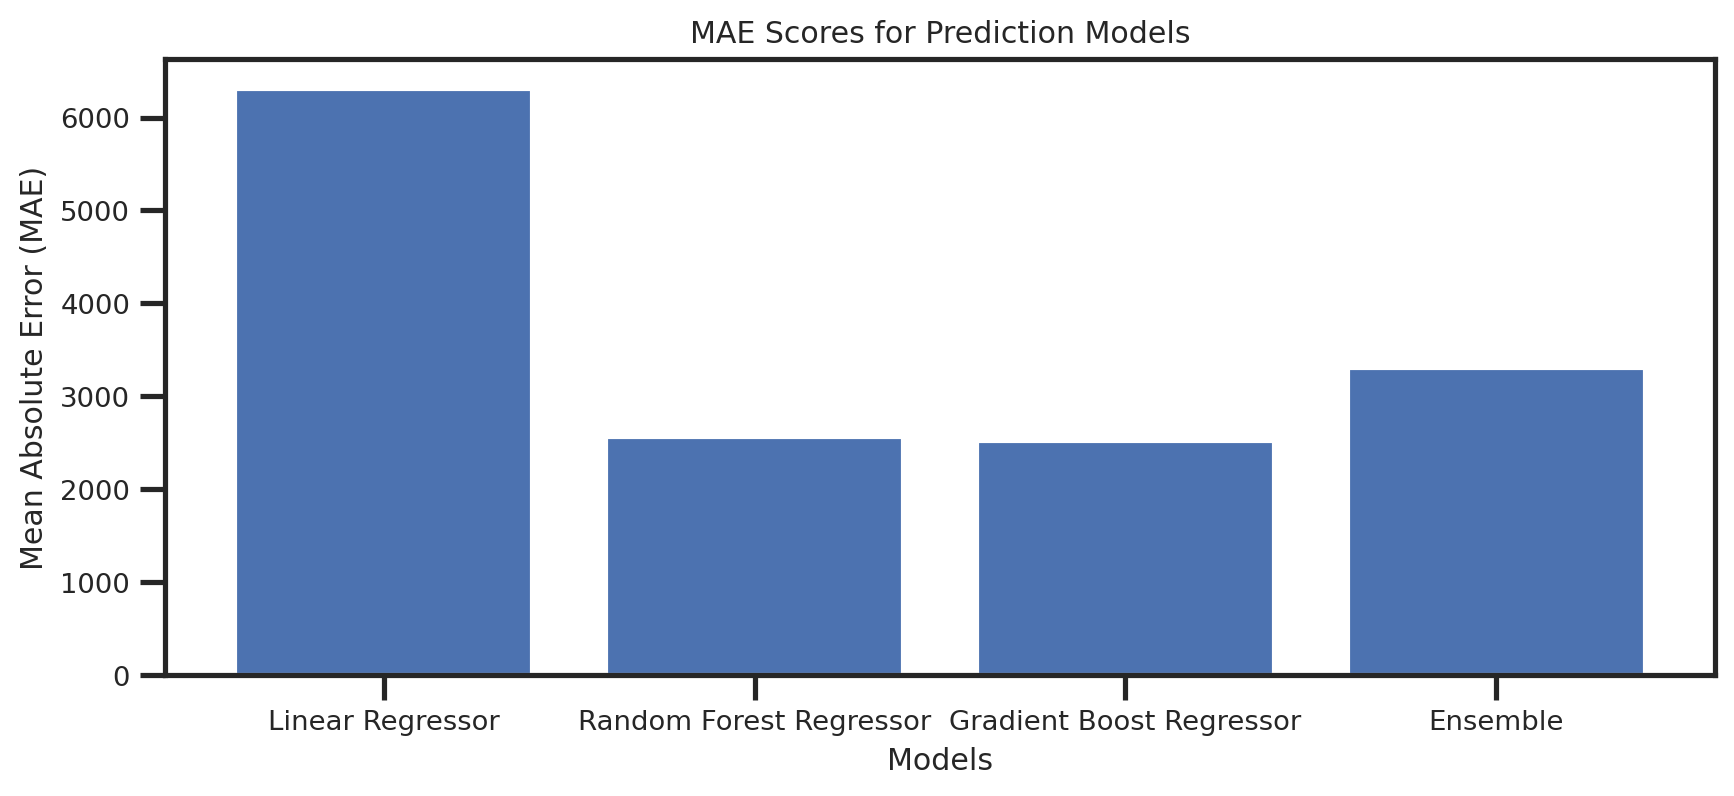

In [ ]:
models = ['Linear Regressor', 'Random Forest Regressor', 'Gradient Boost Regressor', 'Ensemble']
mae_scores = [mean_absolute_error(y_test, LR.predict(X_test_transformed)),
              mean_absolute_error(y_test, RFR.predict(X_test_transformed)),
              mean_absolute_error(y_test, GBR.predict(X_test_transformed)),
              mean_absolute_error(y_test, ensemble.predict(X_test_transformed))]

plt.figure(figsize=(10, 4))
plt.bar(models, mae_scores)
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE Scores for Prediction Models')
plt.show()

## Section 5: Model Evaluation and Analysis

### 5.1 Overall Performance with Cross-Validation

We begin by creating a Cross Validation Score function to calculate the score of each model, then store the scores in a dictionary: 

In [ ]:
def get_cv_scores(model, model_name):
    scores = {}
    score = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring='neg_mean_squared_error')
    scores[model_name] = {'mean': -score.mean(), 'std': score.std()}
    return scores

Calling the cross validation methond and collecting the scores of each model:

In [ ]:
cv_scores = {}
cv_scores.update(get_cv_scores(LR, "Linear Regression"))
cv_scores.update(get_cv_scores(RFR, "RandomForestRegressor"))
cv_scores.update(get_cv_scores(GBR, "GradientBoostRegressor"))
cv_scores.update(get_cv_scores(ensemble, "Esnemble"))

Plotting the model cross validation scores: 

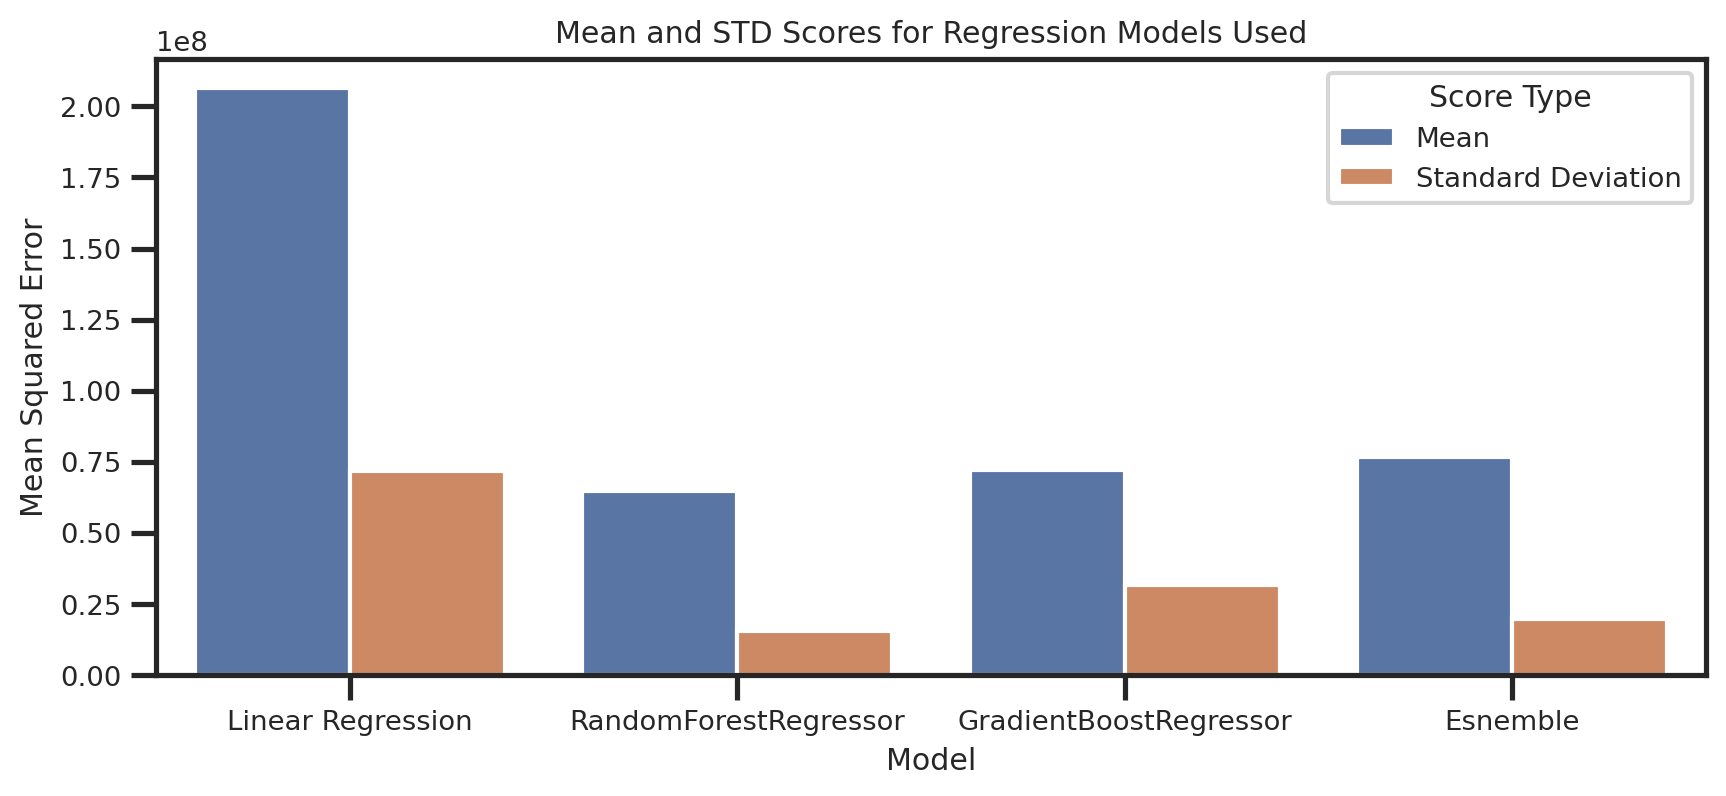

In [ ]:
df_scores = pd.DataFrame.from_dict(cv_scores, orient='index')
df_scores.reset_index(inplace=True)
df_scores.columns = ['Model', 'Mean', 'Standard Deviation']
df_melted = df_scores.melt(id_vars='Model', value_vars=['Mean', 'Standard Deviation'], var_name='Score Type', value_name='Score') # Idea taken from Stackoverflow https://stackoverflow.com/questions/52814833/using-the-melt-function-in-pandas
plt.figure(figsize=(10, 4))
sns.barplot(data=df_melted, x='Model', y='Score', hue='Score Type',)
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Mean and STD Scores for Regression Models Used')
plt.show()

As shown above, each model performs differently with having `GradientBoostRegressor` and `RandomForestRegressor` as the top two accurate models. However, the `LinearRegressor` has the lowest Mean Squared Error. 

### 5.2 True vs Predicted Analysis

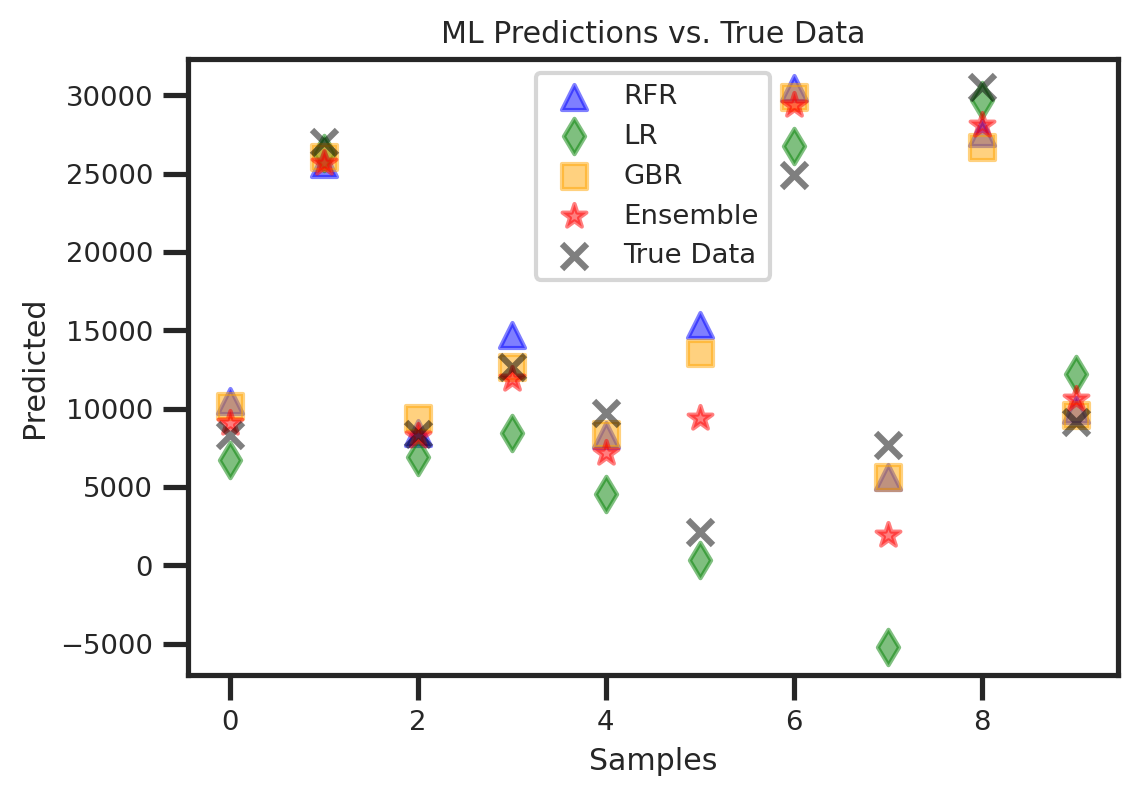

In [ ]:
# The code below are adapted from the lecture colab notebooks
sample_date = X_test_transformed.head(10)
LR_pred = LR.predict(sample_date)
RFR_pred = RFR.predict(sample_date)
GBR_pred = GBR.predict(sample_date)
ensem_Pred = ensemble.predict(sample_date)

#Plotting the number of samples on the x axis, and predictions on the y axis in a scatterplot
plt.scatter(range(len(RFR_pred)), RFR_pred, color='blue', marker='^', alpha=0.5, label='RFR')
plt.scatter(range(len(LR_pred)), LR_pred, color='green', marker='d', alpha=0.5, label='LR')
plt.scatter(range(len(GBR_pred)), GBR_pred, color='orange', marker='s', alpha=0.5, label='GBR')
plt.scatter(range(len(ensem_Pred)), ensem_Pred, color='red', marker='*', alpha=0.5, label='Ensemble')
plt.scatter(range(len(y_test.head(10))), y_test.head(10), color='black', marker='x', alpha=0.5, label='True Data', )
plt.xlabel('Samples')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.title('ML Predictions vs. True Data')
plt.show()

As shown above, the GBR and RFR are making more accurate predictions compared to other models.

### 5.3 Global and Local Explanations with SHAP

SHAP (or Shapley Additive Values), is a an interesting popular apprach used by data scientiests to show the exlaiability of the models.


> As confirmed above, the GBR has the lowest MSE (the lower the better). Hence, it will be used for model's explainability


In [ ]:
# *** The run-time of this block is up to 5 Minutes, unless higher computing unites are used ***

explainer = shap.TreeExplainer(GBR)
shap_values = explainer.shap_values(X_test_transformed)

Plotting the force plot to interpret local interpretability (showing model's behavior on a single observation). For example, we have plotted the SHAP values for the 1345th observation in the test dataset. As shown below, `maker` is highly contributing in increasing the price of this particular car, while `model` and `reg_year` are decrasing it significantly.

In [ ]:
shap.initjs()
# a local explanation with force_plot
row_index = 1345
shap.force_plot(
    explainer.expected_value,
    shap_values[row_index],
    X_test_transformed.iloc[row_index]
)

In the next step, the model's global interpretability will be evaluated throu the summary plot. The Global interpretability helps to explain how each feature affect the overall price of the car. 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


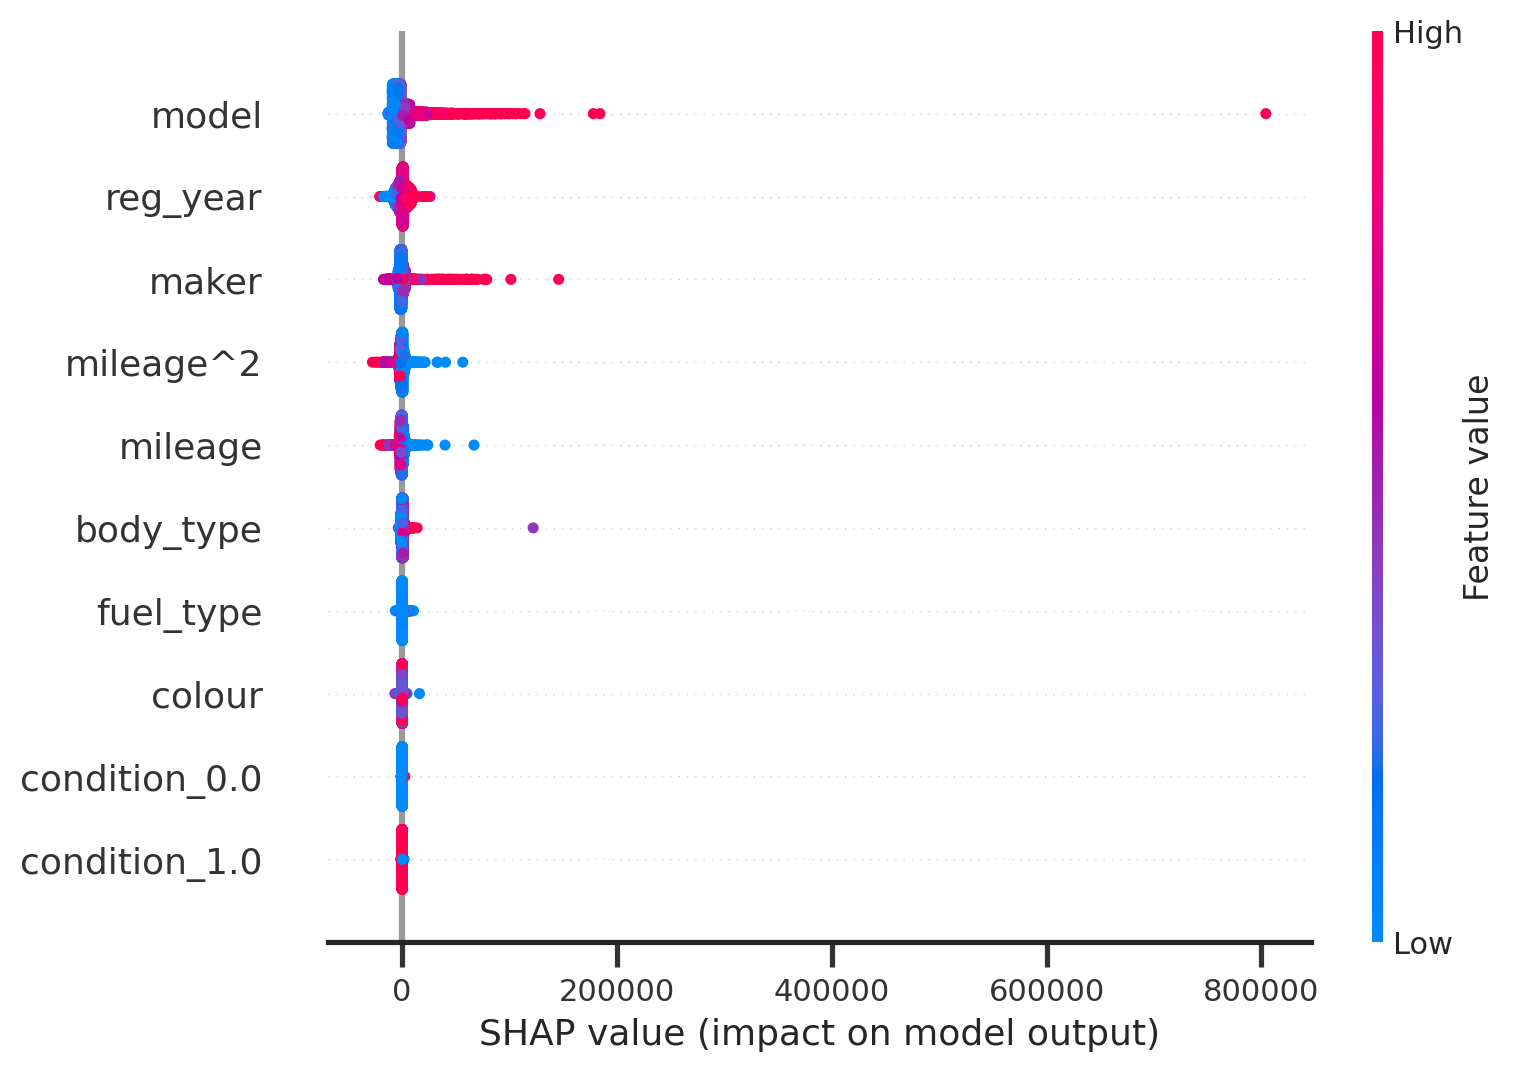

In [ ]:
shap.summary_plot(shap_values, X_test_transformed)

As shown, the `reg_year`, `model` `maker`, and `mileage` are highly considered by the model to determining the price of the car. Also, those features are also making a significant impact when they are integrated with other features (polynomial features). For example, certain car models with certain fuel types are having a significant impact on increasing the price of the car. 

### 5.4 Partial Dependency Plots

Partial Dependency Plots show how much the target variable changes when one feature changes, while all other features are held constant. This can be helpful for understanding how different features contribute to the prediction of the target variable

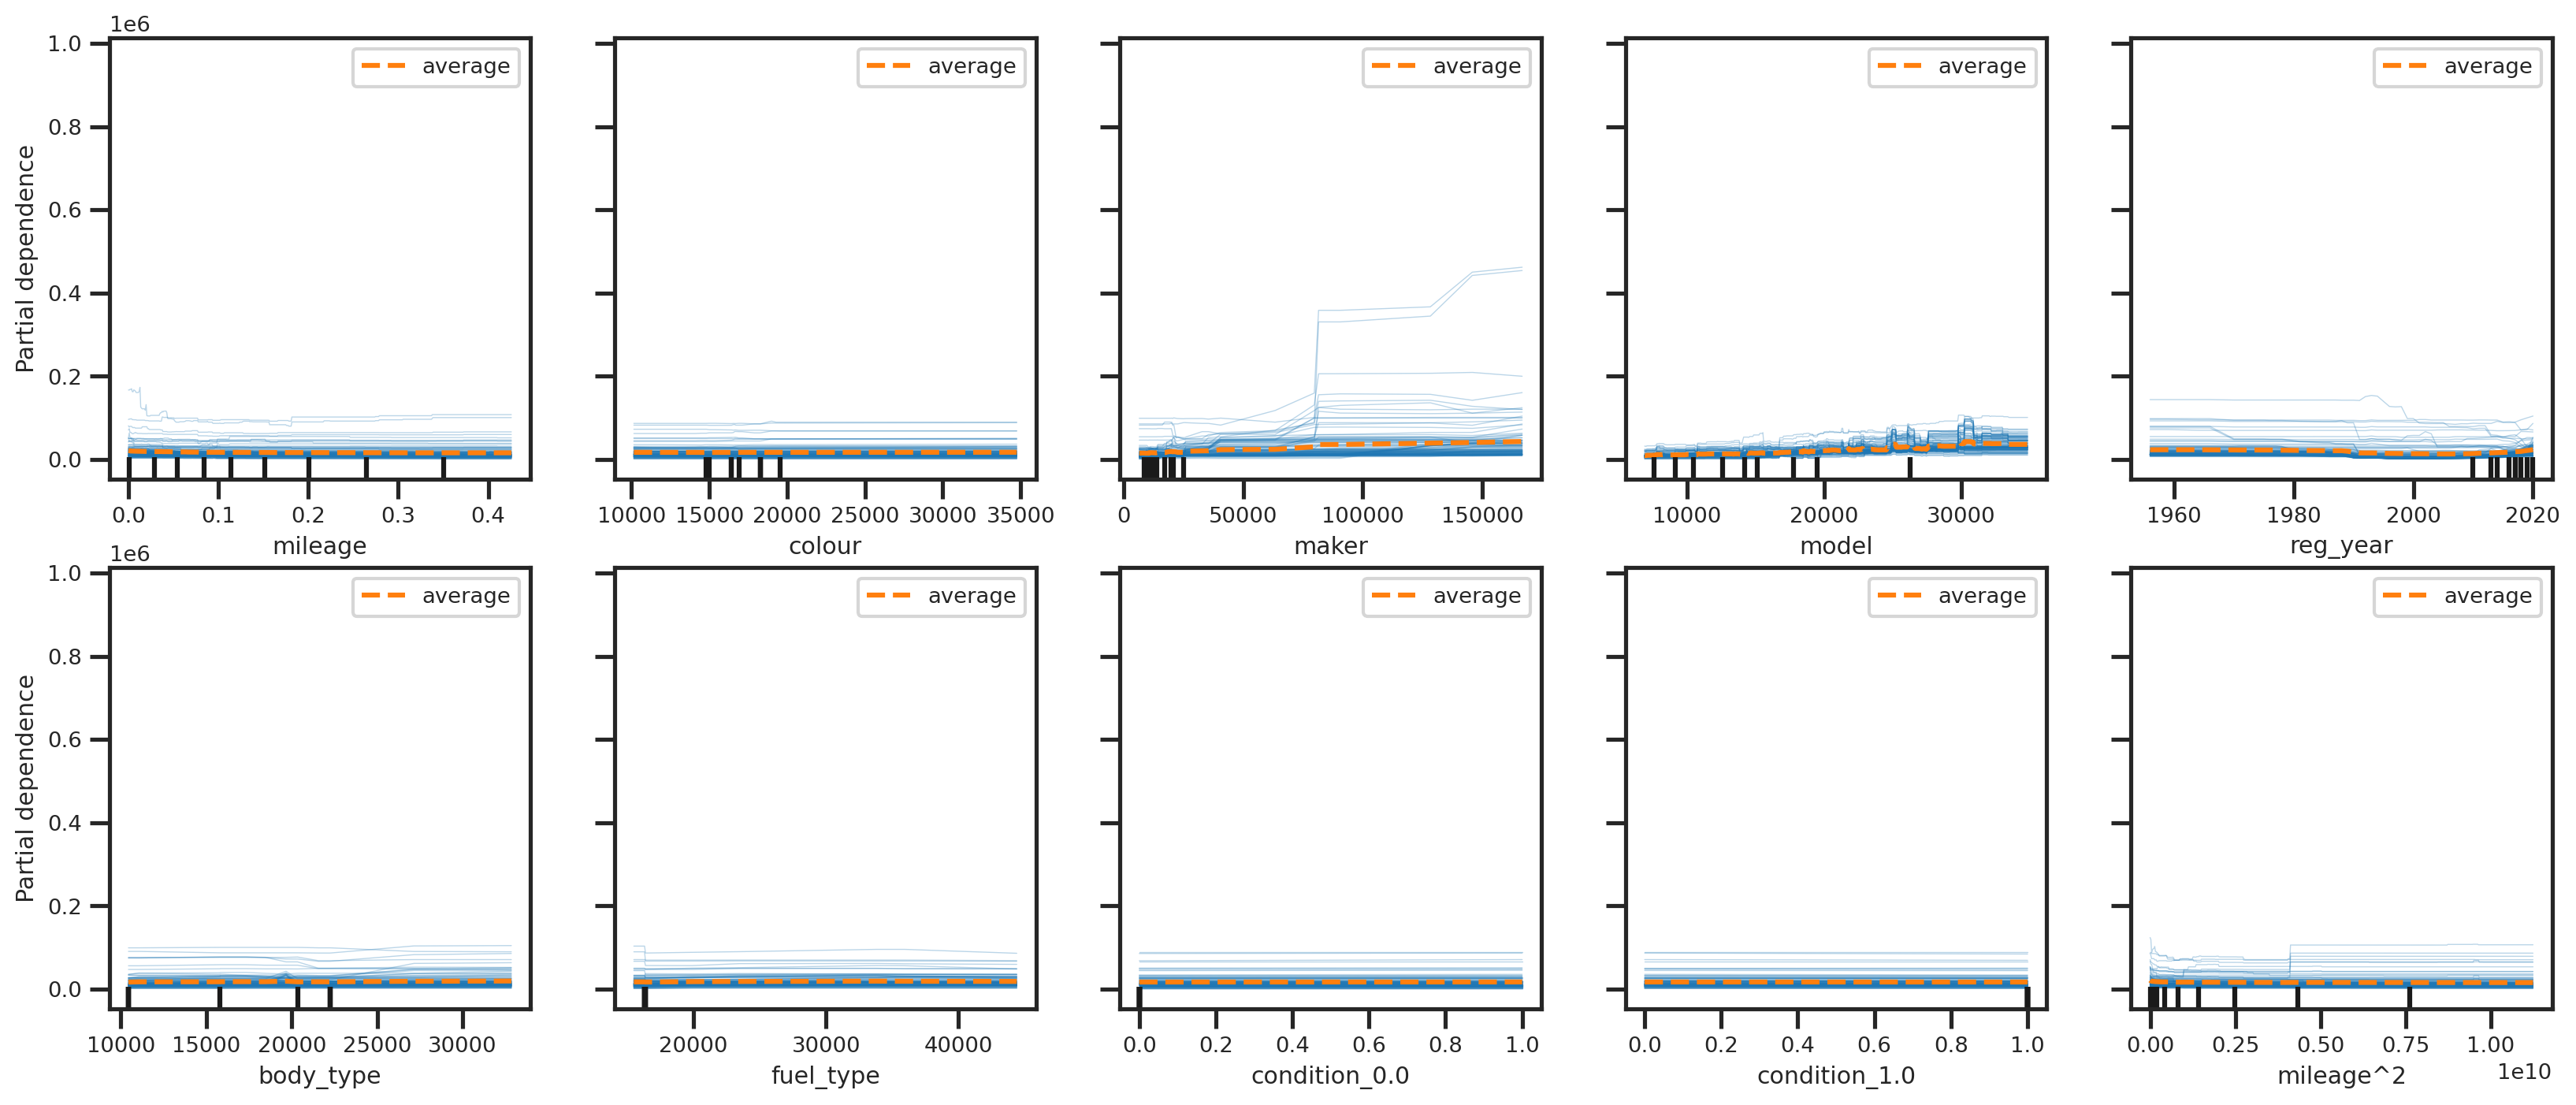

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8), constrained_layout=False)
pdp_display = PartialDependenceDisplay.from_estimator(
    GBR, X_test_transformed, features=X_test_transformed.columns.tolist(),
    kind='both',
    subsample=100, grid_resolution=500, n_jobs=2, random_state=0,
    ax=ax, n_cols=5
)